# 과제2 (우리아이 학습 데이터)
- 연구용 Tabular 데이터의 이해
- 데이터 시각화를 통한 인사이트 습득 방법의 이해
- Scikit-learn 기반의 모델 학습 방법 습득
- Logistic Regression, XGBoost 기반의 모델 학습 방법 습득
- 학습된 모델의 평가 방법 및 시각화 방법 습득

In [578]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, Binarizer, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## 함수 정의

In [579]:
my_random_state = 42
my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    # print(type(y_value), y_value)

    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])

    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

In [580]:
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

### exec_LinearRegression(x_train, y_train, x_test, y_test, n_jobs = -1)

In [581]:
def exec_LinearRegression(x_train, y_train, x_test, y_test, n_jobs = -1):
    model = LinearRegression(n_jobs=n_jobs)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    mse_eval('LinearRegression', pred, y_test)

### exec_Lasso(x_train, y_train, x_test, y_test, alpha_list)

In [582]:
def exec_Lasso(x_train, y_train, x_test, y_test, alpha_list = None):
    alphas = alpha_list if alpha_list is not None else [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, random_state=my_random_state)
        lasso.fit(x_train, y_train)
        pred = lasso.predict(x_test)
        mse_eval('Lasso(alpha={})'.format(alpha), pred, y_test)

### exec_ElasticNet(x_train, y_train, x_test, y_test, alpha, li_ratio_list = None)

In [583]:
def exec_ElasticNet(x_train, y_train, x_test, y_test, alpha, li_ratio_list = None):
    ratios = li_ratio_list if li_ratio_list is not None else [0.2, 0.5, 0.8]
    for ratio in ratios:
        elasticnet = ElasticNet(alpha=alpha, l1_ratio=ratio, random_state=my_random_state)
        elasticnet.fit(x_train, y_train)
        pred = elasticnet.predict(x_test)
        mse_eval('ElasticNet(alpha={0}, l1_ratio={1})'.format(alpha, ratio), pred, y_test)

### exec_PolynomialFeatures_StandardScaler(x_train, y_train, x_test, y_test, degree)

In [584]:
def exec_PolynomialFeatures_StandardScaler(x_train, y_train, x_test, y_test, degree, estimator):
    poly_pipeline = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        estimator
    )
    pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
    mse_eval('{0} (degree={1})'.format(type(estimator), degree), pred, y_test)

### exec_VotingRegressor(x_train, y_train, x_test, y_test, estimator_list, jobs = -1)

In [585]:
# estimators = [
#     ('linear_reg', linear_reg), 
#     ('ridge', ridge), 
#     ('lasso', lasso), 
#     ('elasticnet_pipeline', elasticnet_pipeline), 
#     ('poly_pipeline', poly_pipeline)
# ]
def exec_VotingRegressor(x_train, y_train, x_test, y_test, estimator_list, jobs = -1):
    voting = VotingRegressor(estimators=estimator_list, n_jobs=jobs)
    voting.fit(x_train, y_train)
    pred = voting.predict(x_test)
    mse_eval('Voting Ensemble', pred, y_test)

### exec_RandomForestRegressor(x_train, y_train, x_test, y_test)

In [586]:
def exec_RandomForestRegressor(x_train, y_train, x_test, y_test):
    estimator = RandomForestRegressor(random_state=my_random_state)
    estimator.fit(x_train, y_train)
    pred = estimator.predict(x_test)
    mse_eval('RandomForest Ensemble', pred, y_test)

### exe_RandomForestRegressor_tuning(x_train, y_train, x_test, y_test, n_estimators = 1000, max_depth = 7, max_features = 0.9)

In [587]:
def exe_RandomForestRegressor_tuning(x_train, y_train, x_test, y_test, n_estimators = 1000, max_depth = 7, max_features = 0.9):
    estimator = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=my_random_state)
    estimator.fit(x_train, y_train)
    pred = estimator.predict(x_test)
    mse_eval('RandomForest Ensemble Tuning', pred, y_test)

### exec_GradientBoostingRegressor(x_train, y_train, x_test, y_test)

In [588]:
def exec_GradientBoostingRegressor(x_train, y_train, x_test, y_test):
    gbr = GradientBoostingRegressor(random_state=my_random_state)
    gbr.fit(x_train, y_train)
    pred = gbr.predict(x_test)
    mse_eval('GradientBoost Ensemble', pred, y_test)

### exec_GradientBoostingRegressor_tuning(x_train, y_train, x_test, y_test, learning_rate=0.01)

In [589]:
def exec_GradientBoostingRegressor_tuning(x_train, y_train, x_test, y_test, learning_rate=0.01, n_estimators=1000, subsample=0.8):
    gbr = GradientBoostingRegressor(random_state=my_random_state, learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample)
    gbr.fit(x_train, y_train)
    pred = gbr.predict(x_test)
    mse_eval('GradientBoost Ensemble tuning (lr={0},est={1},subsample={2})'.format(learning_rate, n_estimators, subsample), pred, y_test)

### exec_XGBRegressor(x_train, y_train, x_test, y_test)

In [590]:
def exec_XGBRegressor(x_train, y_train, x_test, y_test):
    xgb = XGBRegressor(random_state=my_random_state)
    xgb.fit(x_train, y_train)
    pred = xgb.predict(x_test)
    mse_eval('XGBoost', pred, y_test)

### exec_XGBRegressor(x_train, y_train, x_test, y_test, learning_rate=0.01, n_estimators=1000, subsample=0.8, max_features=0.8, max_depth=7)

In [591]:
def exec_XGBRegressor_tuning(x_train, y_train, x_test, y_test, learning_rate=0.01, n_estimators=1000, subsample=0.8, max_features=0.8, max_depth=7):
    xgb = XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_features=max_features, max_depth=max_depth, random_state=my_random_state)
    xgb.fit(x_train, y_train)
    pred = xgb.predict(x_test)
    mse_eval('XGBoost Tuning (lr={0},est={1},ss={2},mf={3}, md={4})'.format(learning_rate, n_estimators, subsample, max_features, max_depth), pred, y_test)

### exec_LGBMRegressor(x_train, y_train, x_test, y_test)

In [592]:
def exec_LGBMRegressor(x_train, y_train, x_test, y_test):
    lgbm = LGBMRegressor(random_state=my_random_state, verbose=-1)
    lgbm.fit(x_train, y_train)
    pred = lgbm.predict(x_test)
    mse_eval('LGBM', pred, y_test)

### exec_LGBMRegressor(x_train, y_train, x_test, y_test, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.9, subsample=0.9, max_depth=7)

In [593]:
def exec_LGBMRegressor_tuning(x_train, y_train, x_test, y_test, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.9, subsample=0.9, max_depth=7):
    lgbm = LGBMRegressor(random_state=my_random_state, learning_rate=learning_rate, n_estimators=n_estimators, colsample_bytree=colsample_bytree, subsample=subsample, max_depth=max_depth)
    lgbm.fit(x_train, y_train)
    pred = lgbm.predict(x_test)
    mse_eval('LGBM Tuning (lr={0},est={1},cb={2},ss={3},md={4})'.format(learning_rate, n_estimators, colsample_bytree, subsample, max_depth), pred, y_test)

### exec_StackingRegressor(x_train, y_train, x_test, y_test, n_jobs=-1)

In [594]:
# stack_models = [
#     ('elasticnet', poly_pipeline), 
#     ('randomforest', rfr), 
#     ('gbr', gbr),
#     ('lgbm', lgbm),
# ]
def exec_StackingRegressor(x_train, y_train, x_test, y_test, estimators, n_jobs=-1):
    xgb = XGBRegressor(random_state=my_random_state)
    stack_reg = StackingRegressor(estimators, final_estimator=xgb, n_jobs=n_jobs)
    stack_reg.fit(x_train, y_train)
    pred = stack_reg.predict(x_test)
    mse_eval('Stacking Ensemble', pred, y_test)

### exec_kfold(estimator, x_data_df, y_data_s, folds=5)

In [595]:
def exec_kfold(estimator, x_data_df, y_data_s, folds=5):
    kfold = KFold(n_splits=folds)
    mse_score_list = []
    print(type(estimator))
    for iter_count, (train_index, test_index) in enumerate(kfold.split(x_data_df)):
        x_train, x_test = x_data_df.values[train_index], x_data_df.values[test_index]
        y_train, y_test = y_data_s.values[train_index], y_data_s.values[test_index]
        # 학습 & 예측 & 정확도 계산
        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_score_list.append(mse)
        print("#{0}. 교차 검증 MSE: {1:.4f}".format(iter_count, mse))
    print("평균 MSE: {0:.4f}".format(np.mean(mse_score_list)))

### exec_stratified_kfold(clf, x_data_df, y_data_s, folds=5)

In [596]:
def exec_stratified_kfold(estimator, x_data_df, y_data_s, folds=5):
    skf = StratifiedKFold(n_splits=folds)
    mse_score_list = []
    print(type(estimator))
    for iter_count, (train_index, test_index) in enumerate(skf.split(x_data_df, y_data_s)):
        x_train, x_test = x_data_df.values[train_index], x_data_df.values[test_index]
        y_train, y_test = y_data_s.values[train_index], y_data_s.values[test_index]
        # 학습 & 예측 & 정확도 계산
        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_score_list.append(mse)
        print("#{0}. 교차 검증 MSE: {1:.4f}".format(iter_count, mse))
    print("평균 MSE: {0:.4f}".format(np.mean(mse_score_list)))

### exec_RandomizedSearchCV_LGBMRegressor(x_train, y_train, x_test, y_test, cv=5, iter=25)

In [597]:
def exec_RandomizedSearchCV_LGBMRegressor(x_train, y_train, x_test, y_test, cv=5, iter=25):
    param_dict = {
        'n_estimators': [200, 500, 1000, 2000], 
        'learning_rate': [0.1, 0.05, 0.01], 
        'max_depth': [6, 7, 8], 
        'colsample_bytree': [0.8, 0.9, 1.0], 
        'subsample': [0.8, 0.9, 1.0],
    } 
    estimator = LGBMRegressor(random_state=my_random_state)
    grid_dtree = RandomizedSearchCV(estimator, param_grid=param_dict, cv=cv, n_iter=iter, scoring='neg_mean_squared_error')
    grid_dtree.fit(x_train, y_train)
    y_pred = grid_dtree.best_estimator_.predict(x_test)
    print(type(estimator))
    print("Best Parameter : ", grid_dtree.best_params_)
    print("Best Score : ", grid_dtree.best_score_)
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    

### exec_GridSearchCV_LGBMRegressor(x_train, y_train, x_test, y_test, cv=5)

In [598]:
def exec_GridSearchCV_LGBMRegressor(x_train, y_train, x_test, y_test, cv=5, jobs=-1):
    param_dict = {
        'n_estimators': [500, 1000], 
        'learning_rate': [0.1, 0.05, 0.01], 
        'max_depth': [7, 8], 
        'colsample_bytree': [0.8, 0.9], 
        'subsample': [0.8, 0.9,],
    }    
    estimator = LGBMRegressor(random_state=my_random_state)
    grid_dtree = GridSearchCV(estimator, param_grid=param_dict, cv=cv, n_jobs=jobs, scoring='neg_mean_squared_error', refit=True)
    grid_dtree.fit(x_train, y_train)
    y_pred = grid_dtree.best_estimator_.predict(x_test)
    print(type(estimator))
    print("Best Parameter : ", grid_dtree.best_params_)
    print("Best Score : ", grid_dtree.best_score_)
    print("Accuracy : ", accuracy_score(y_test, y_pred))

### exec_label_encoding(column_name_list, df)

In [599]:
def exec_label_encoding(column_name_list, df):
    label_name_dict = {} # {column_name : label_name_list}
    for column_name in column_name_list:
        le = LabelEncoder()
        df[column_name] = le.fit_transform(df[column_name])
        label_name_dict[column_name] = le.classes_
    return label_name_dict

## 데이터 분석
- gender: 학생의 성별 (M: 남성, F: 여성)
- NationaliTy: 학생의 국적
- PlaceofBirth: 학생이 태어난 국가
- StageID: 학생이 다니는 학교 (초,중,고)
- GradeID: 학생이 속한 성적 등급
- SectionID: 학생이 속한 반 이름
- Topic: 수강한 과목
- Semester: 수강한 학기 (1학기/2학기)
- Relation: 주 보호자와 학생의 관계
- raisedhands: 학생이 수업 중 손을 든 횟수
- VisITedResources: 학생이 과목 공지를 확인한 횟수
- Discussion: 학생이 토론 그룹에 참여한 횟수
- ParentAnsweringSurvey: 부모가 학교 설문에 참여했는지 여부
- ParentschoolSatisfaction: 부모가 학교에 만족했는지 여부
- StudentAbscenceDays: 학생의 결석 횟수 (7회 이상/미만)
- Class: 학생의 성적 등급 (L: 낮음, M: 보통, H: 높음)

In [600]:
df = pd.read_csv("xAPI-Edu-Data.csv")
print(type(df), df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'> (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


### 데이터 확인

In [601]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  ParentschoolSatisfaction  

In [602]:
print(df['Class'].value_counts())

Class
M    211
H    142
L    127
Name: count, dtype: int64


In [603]:
df.describe()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


## 데이터 전처리

#### Label Encoding

In [604]:
label_column_list = df.select_dtypes(include=["object"]).columns.tolist()
print(len(label_column_list), label_column_list)

13 ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays', 'Class']


In [605]:
labeled_df = df.copy()
for label_column in label_column_list:
    label_encoder = LabelEncoder()
    label_encoder.fit(df[label_column])
    labeled_df[label_column] = label_encoder.transform(df[label_column])
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   gender                    480 non-null    int64
 1   NationalITy               480 non-null    int64
 2   PlaceofBirth              480 non-null    int64
 3   StageID                   480 non-null    int64
 4   GradeID                   480 non-null    int64
 5   SectionID                 480 non-null    int64
 6   Topic                     480 non-null    int64
 7   Semester                  480 non-null    int64
 8   Relation                  480 non-null    int64
 9   raisedhands               480 non-null    int64
 10  VisITedResources          480 non-null    int64
 11  AnnouncementsView         480 non-null    int64
 12  Discussion                480 non-null    int64
 13  ParentAnsweringSurvey     480 non-null    int64
 14  ParentschoolSatisfaction  480 non-null    

In [606]:
corr_df = labeled_df.corr()
corr_df['Class'].sort_values(ascending=False)

Class                       1.000000
gender                      0.123675
Topic                       0.103610
SectionID                   0.017597
GradeID                     0.013483
StageID                    -0.011696
Semester                   -0.043287
NationalITy                -0.077785
PlaceofBirth               -0.098975
Discussion                 -0.121971
ParentAnsweringSurvey      -0.123254
AnnouncementsView          -0.143996
ParentschoolSatisfaction   -0.146277
VisITedResources           -0.161748
StudentAbsenceDays         -0.199083
raisedhands                -0.231016
Relation                   -0.272111
Name: Class, dtype: float64

## 학습 데이터 분리

In [607]:
x_data = labeled_df.iloc[:, :-1] # DataFrame
y_data = labeled_df.iloc[:, -1] # Series
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=my_random_state, stratify=y_data)
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
print(y_train.value_counts())
print(type(x_test), x_test.shape)
print(type(y_test), y_test.shape)
print(y_test.value_counts())
x_data.head()

<class 'pandas.core.frame.DataFrame'> (384, 16)
<class 'pandas.core.series.Series'> (384,)
Class
2    169
0    113
1    102
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'> (96, 16)
<class 'pandas.core.series.Series'> (96,)
Class
2    42
0    29
1    25
Name: count, dtype: int64


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays
0,1,4,4,2,1,0,7,0,0,15,16,2,20,1,1,1
1,1,4,4,2,1,0,7,0,0,20,20,3,25,1,1,1
2,1,4,4,2,1,0,7,0,0,10,7,0,30,0,0,0
3,1,4,4,2,1,0,7,0,0,30,25,5,35,0,0,0
4,1,4,4,2,1,0,7,0,0,40,50,12,50,0,0,0


## 학습 알고리즘 검토

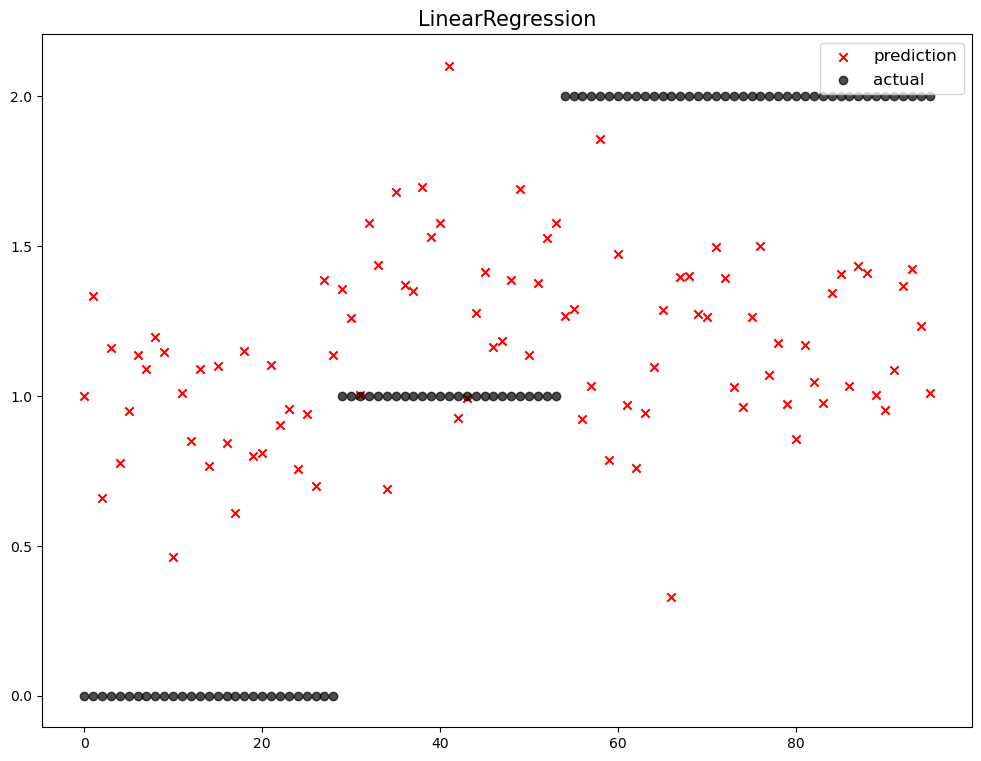

              model       mse
0  LinearRegression  0.684775


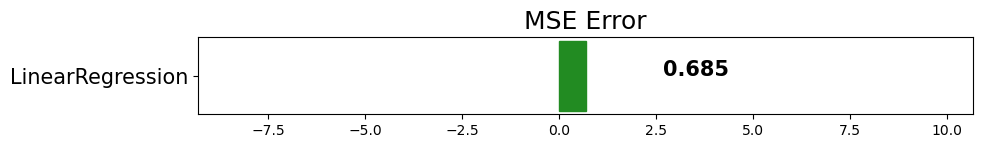

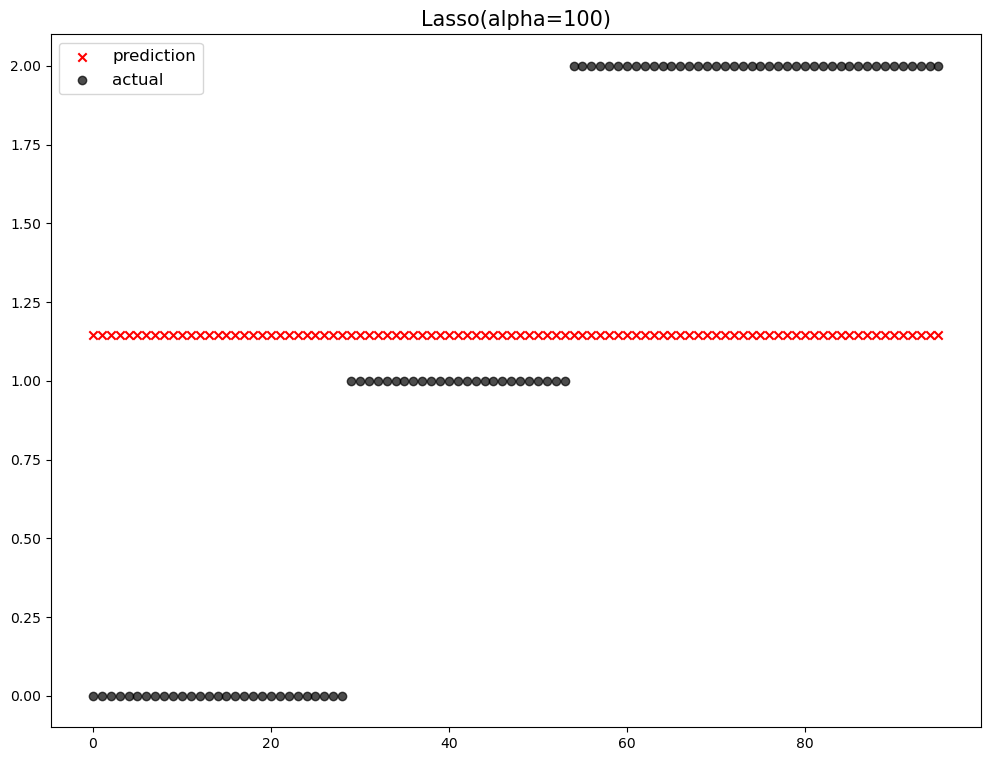

              model       mse
0  Lasso(alpha=100)  0.721354
1  LinearRegression  0.684775


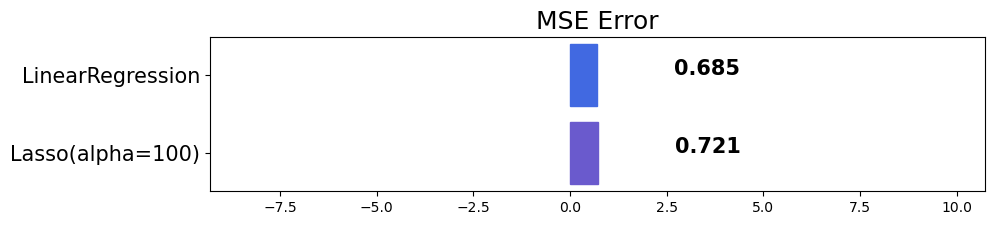

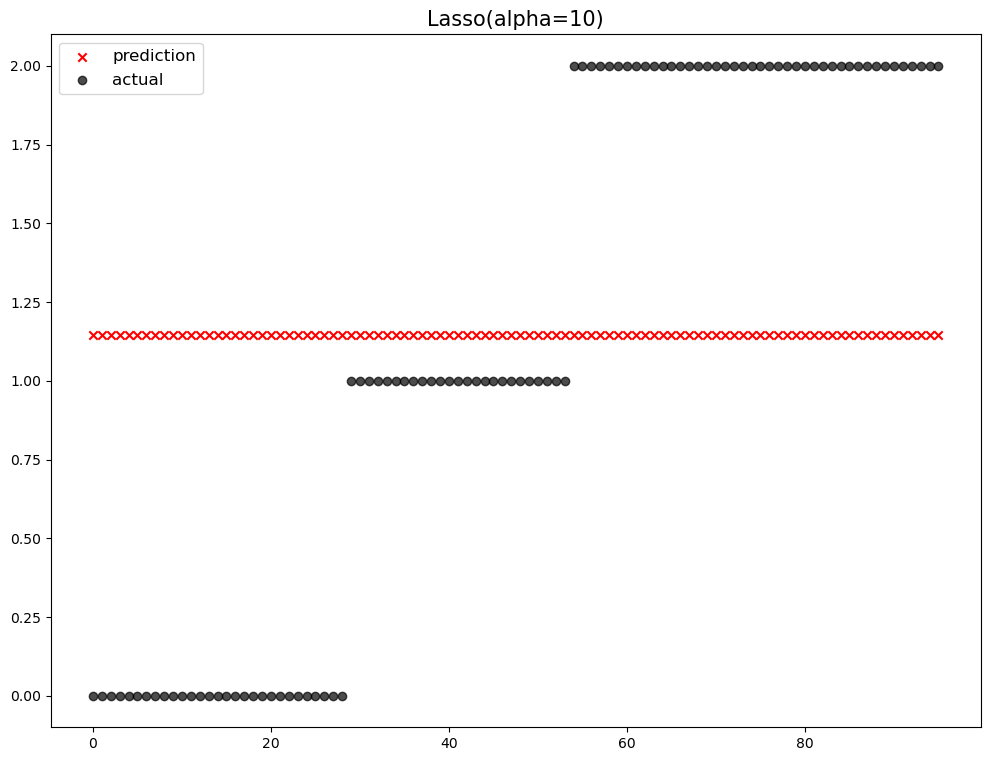

              model       mse
0  Lasso(alpha=100)  0.721354
1   Lasso(alpha=10)  0.721354
2  LinearRegression  0.684775


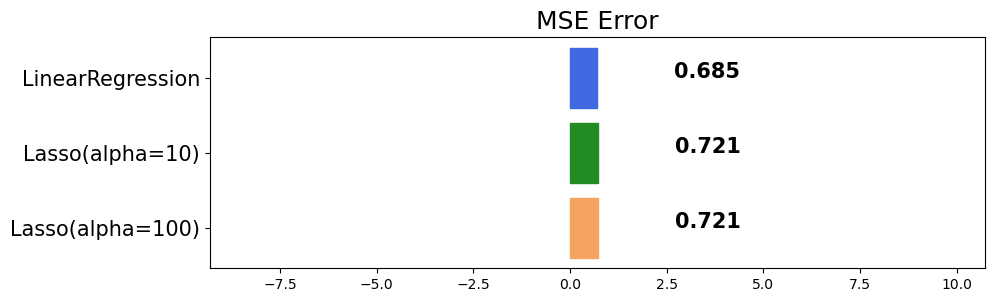

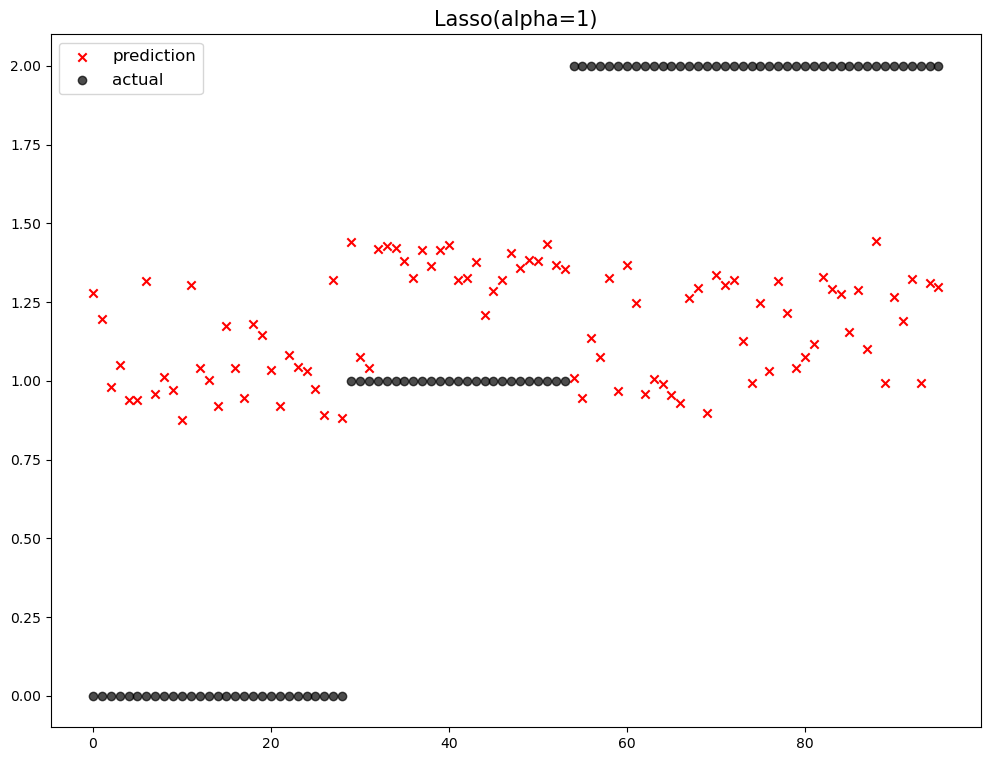

              model       mse
0  Lasso(alpha=100)  0.721354
1   Lasso(alpha=10)  0.721354
2    Lasso(alpha=1)  0.690370
3  LinearRegression  0.684775


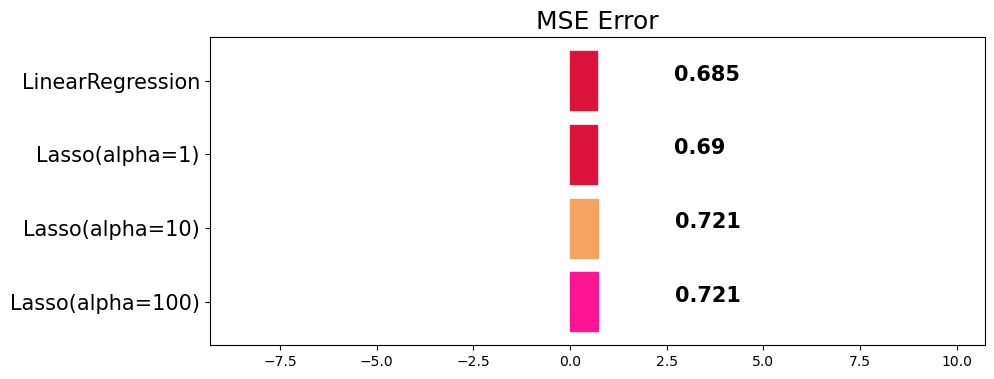

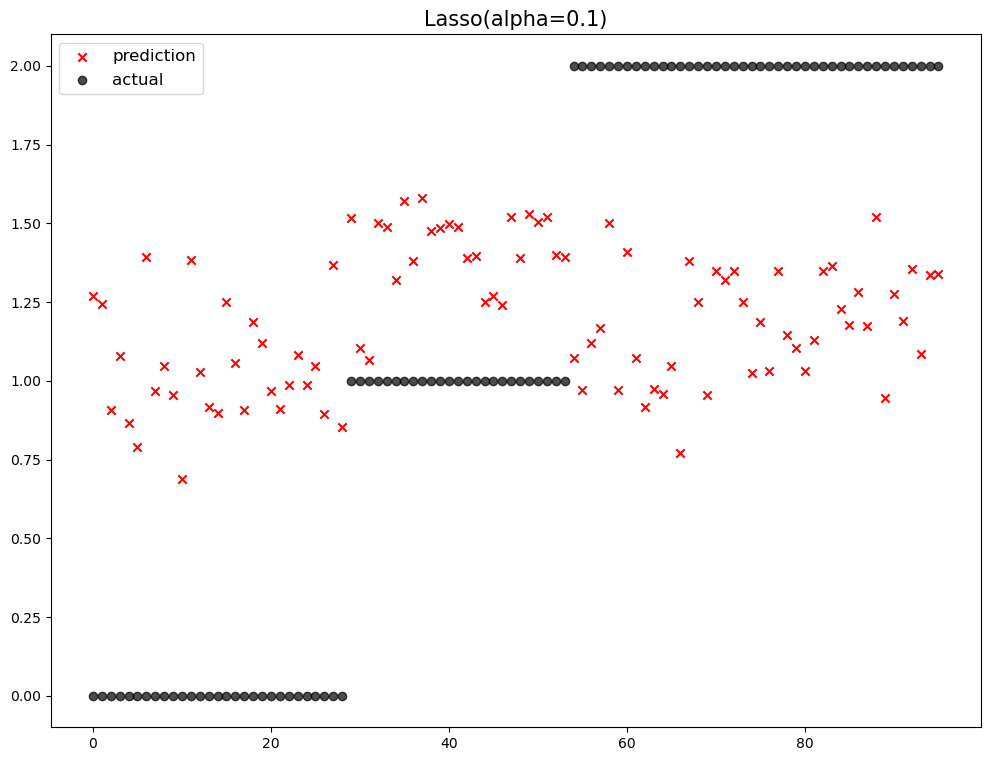

              model       mse
0  Lasso(alpha=100)  0.721354
1   Lasso(alpha=10)  0.721354
2  Lasso(alpha=0.1)  0.692206
3    Lasso(alpha=1)  0.690370
4  LinearRegression  0.684775


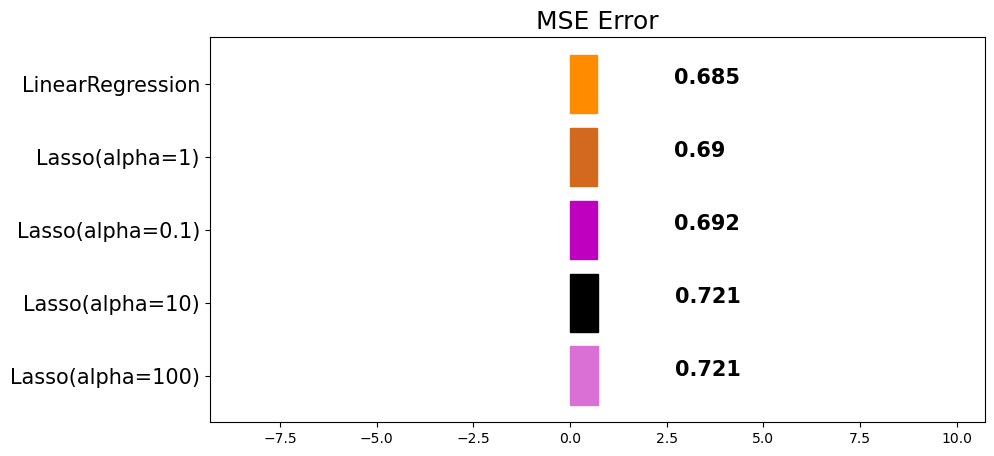

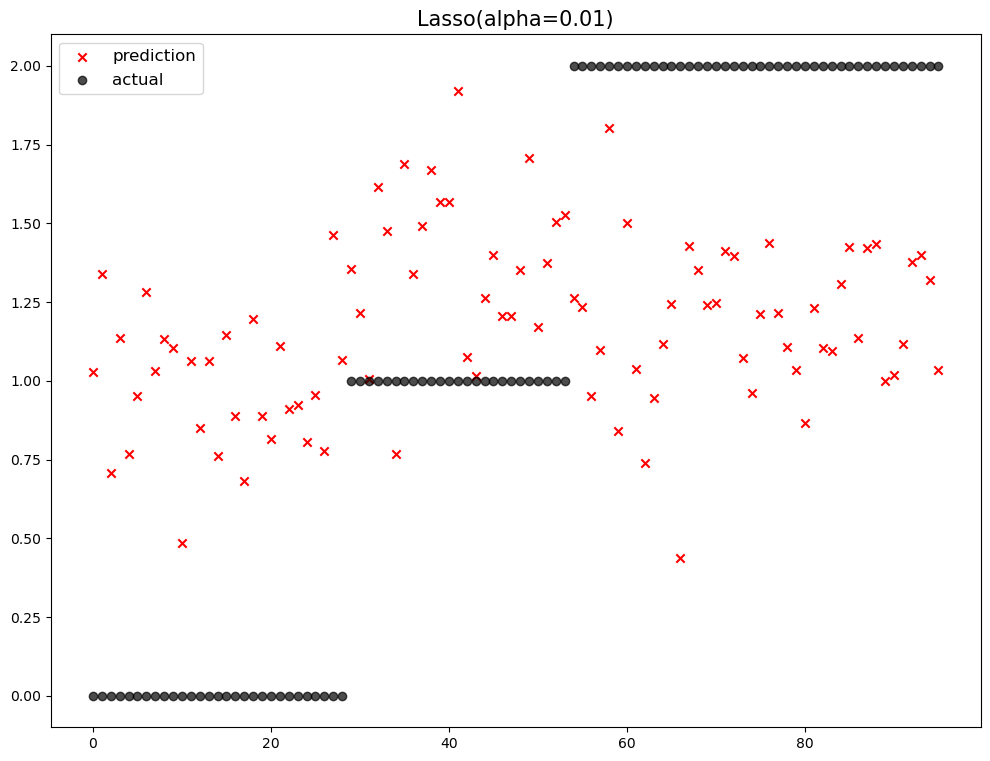

               model       mse
0   Lasso(alpha=100)  0.721354
1    Lasso(alpha=10)  0.721354
2   Lasso(alpha=0.1)  0.692206
3     Lasso(alpha=1)  0.690370
4   LinearRegression  0.684775
5  Lasso(alpha=0.01)  0.674036


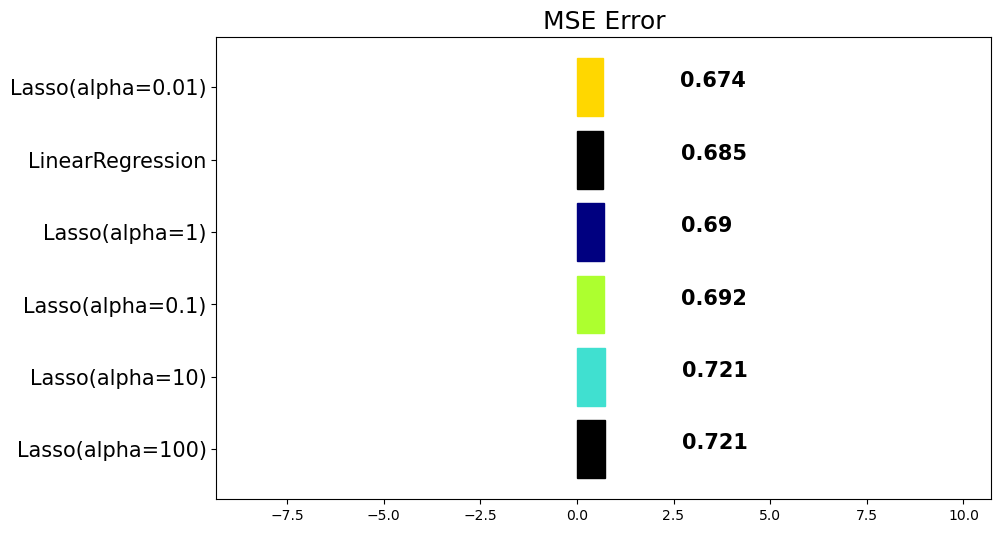

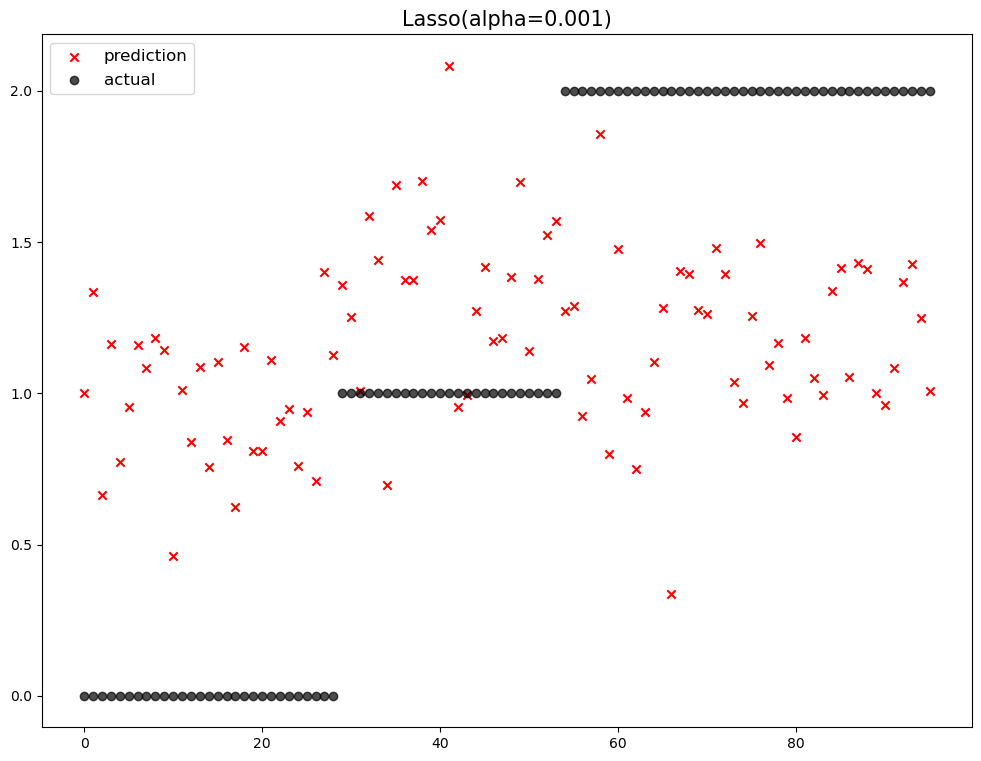

                model       mse
0    Lasso(alpha=100)  0.721354
1     Lasso(alpha=10)  0.721354
2    Lasso(alpha=0.1)  0.692206
3      Lasso(alpha=1)  0.690370
4    LinearRegression  0.684775
5  Lasso(alpha=0.001)  0.682624
6   Lasso(alpha=0.01)  0.674036


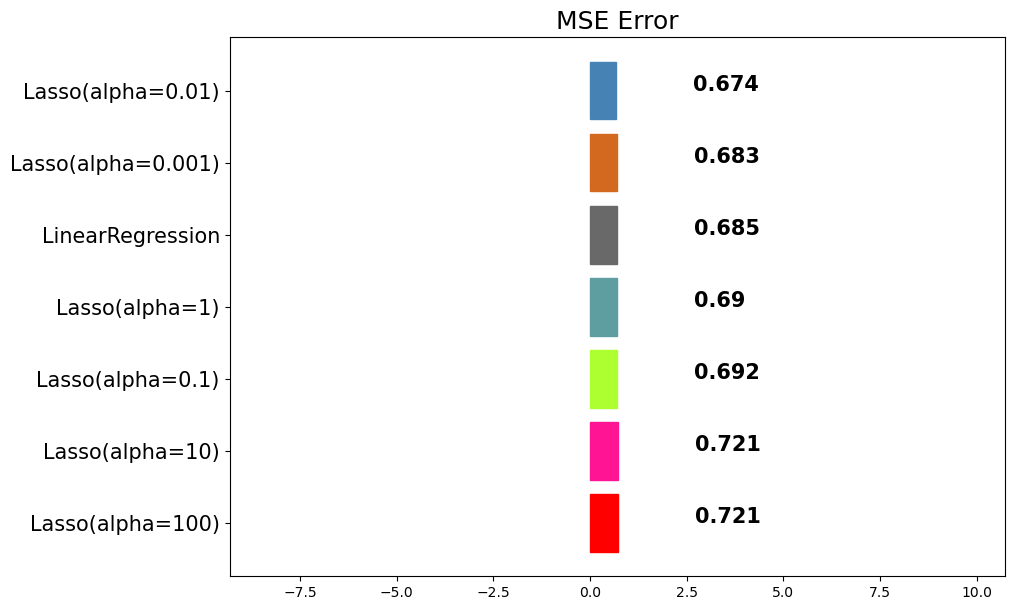

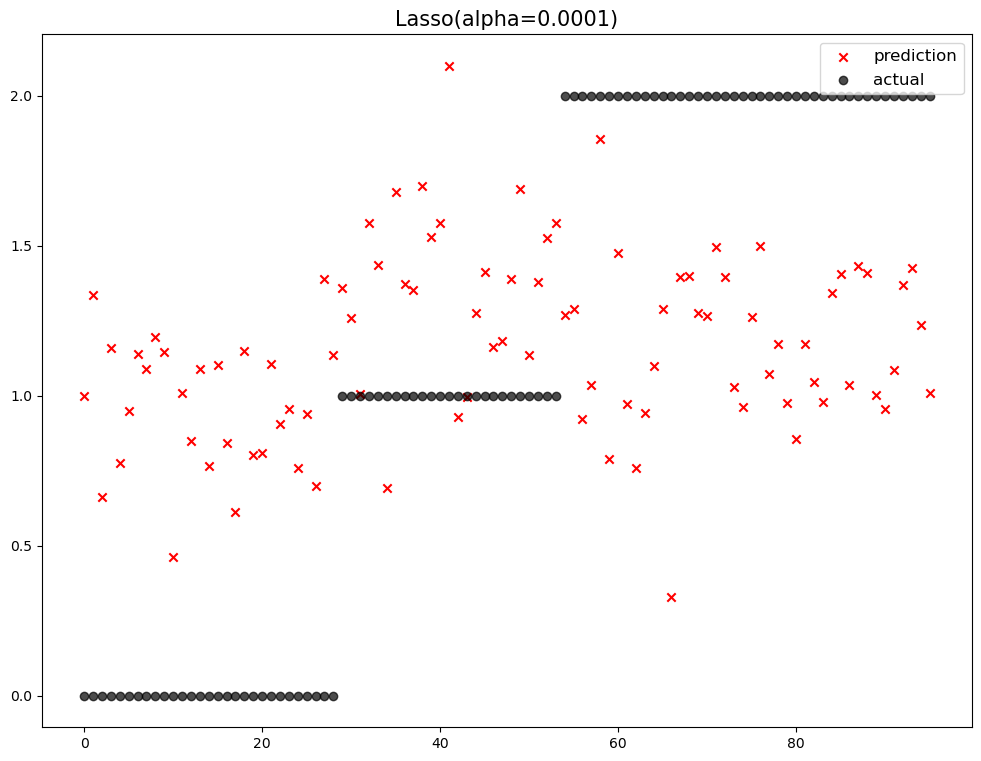

                 model       mse
0     Lasso(alpha=100)  0.721354
1      Lasso(alpha=10)  0.721354
2     Lasso(alpha=0.1)  0.692206
3       Lasso(alpha=1)  0.690370
4     LinearRegression  0.684775
5  Lasso(alpha=0.0001)  0.684560
6   Lasso(alpha=0.001)  0.682624
7    Lasso(alpha=0.01)  0.674036


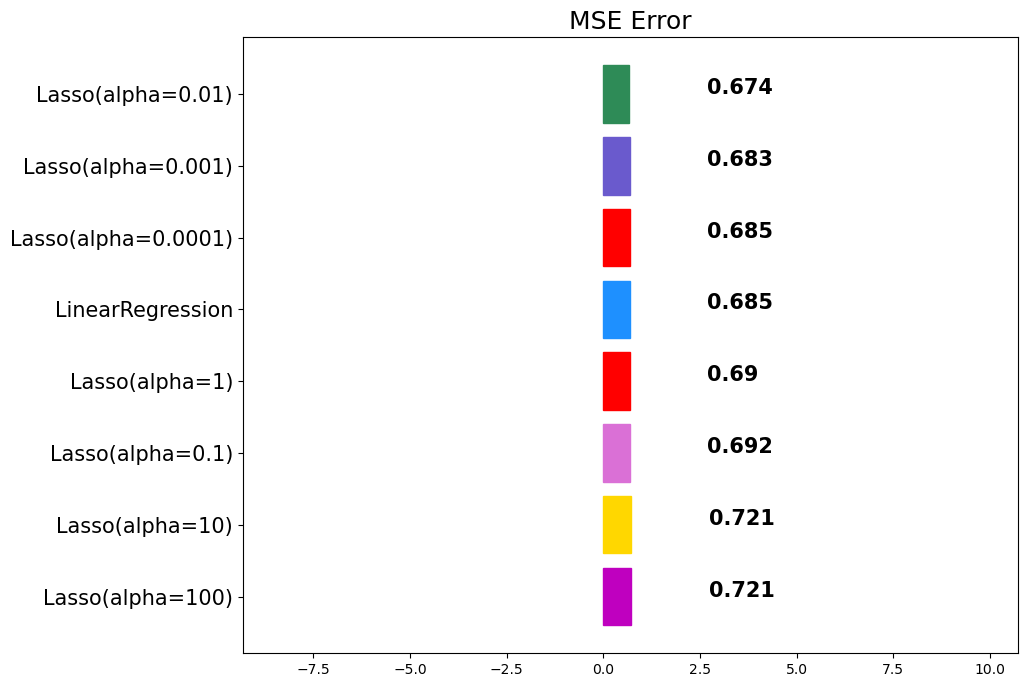

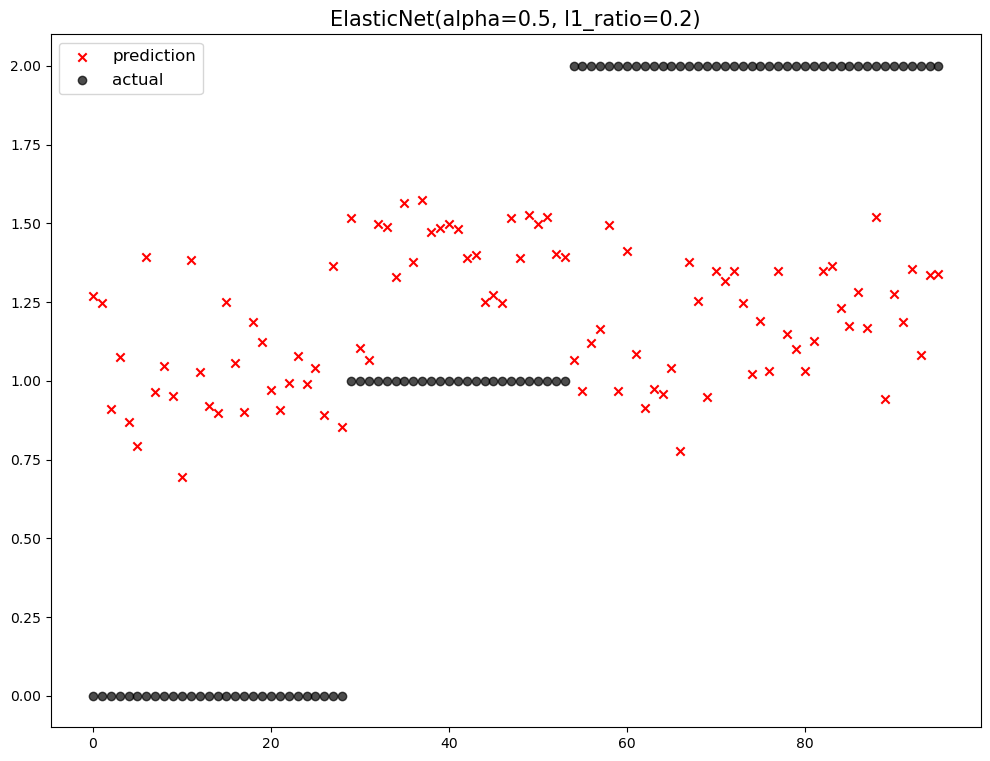

                                 model       mse
0                     Lasso(alpha=100)  0.721354
1                      Lasso(alpha=10)  0.721354
2  ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
3                     Lasso(alpha=0.1)  0.692206
4                       Lasso(alpha=1)  0.690370
5                     LinearRegression  0.684775
6                  Lasso(alpha=0.0001)  0.684560
7                   Lasso(alpha=0.001)  0.682624
8                    Lasso(alpha=0.01)  0.674036


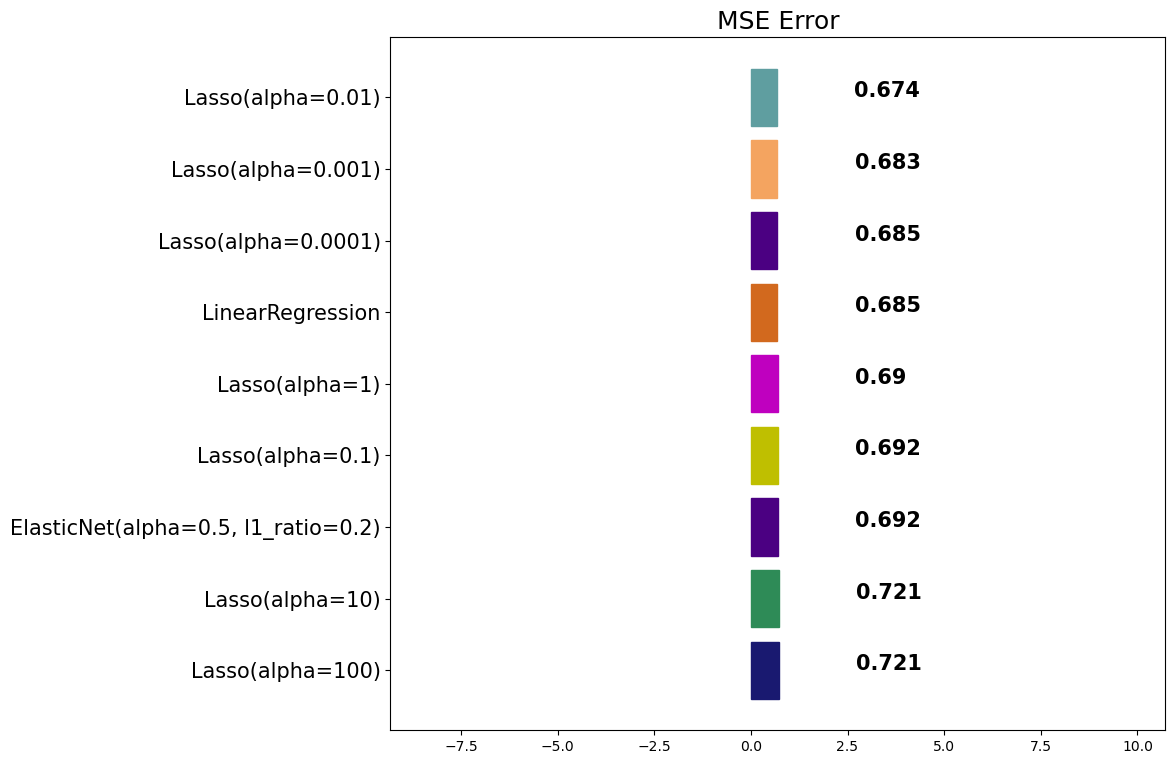

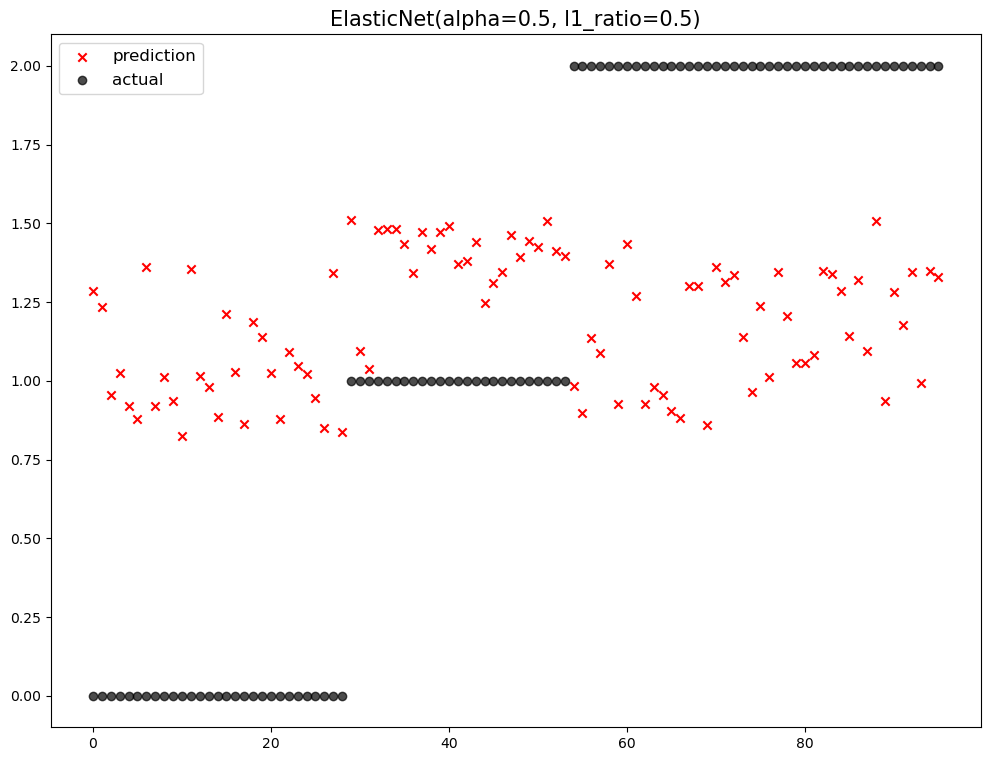

                                 model       mse
0                     Lasso(alpha=100)  0.721354
1                      Lasso(alpha=10)  0.721354
2  ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3  ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
4                     Lasso(alpha=0.1)  0.692206
5                       Lasso(alpha=1)  0.690370
6                     LinearRegression  0.684775
7                  Lasso(alpha=0.0001)  0.684560
8                   Lasso(alpha=0.001)  0.682624
9                    Lasso(alpha=0.01)  0.674036


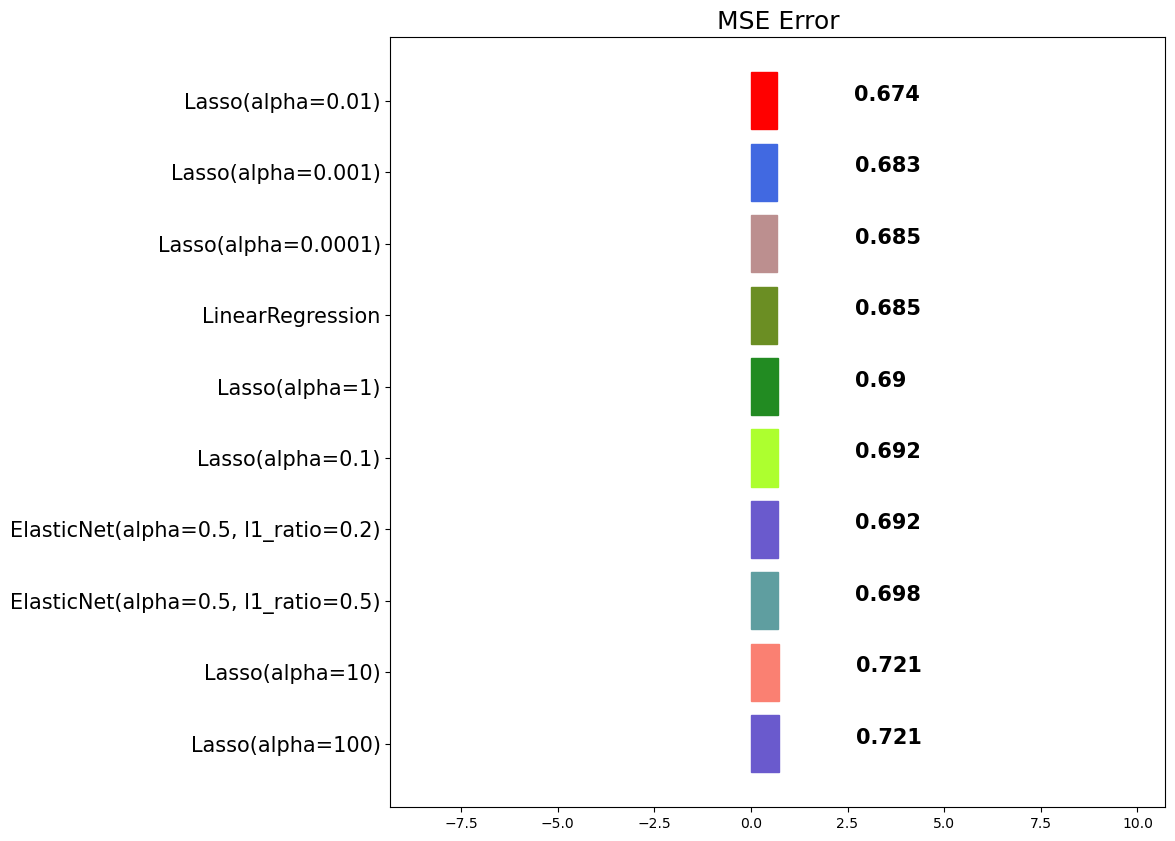

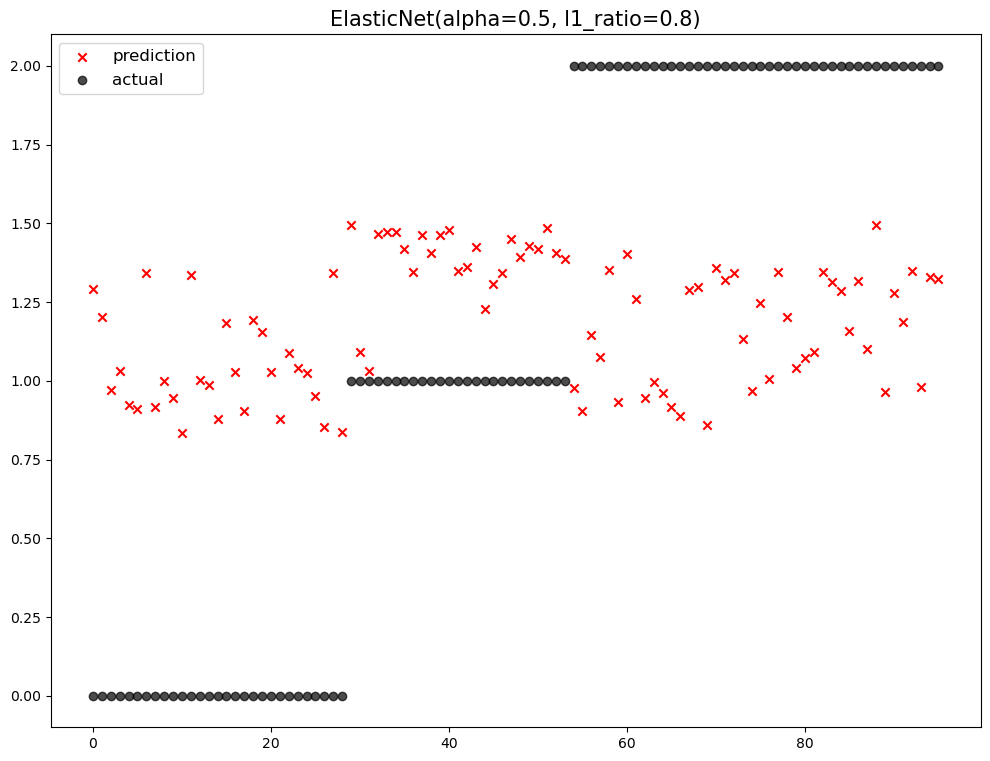

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036


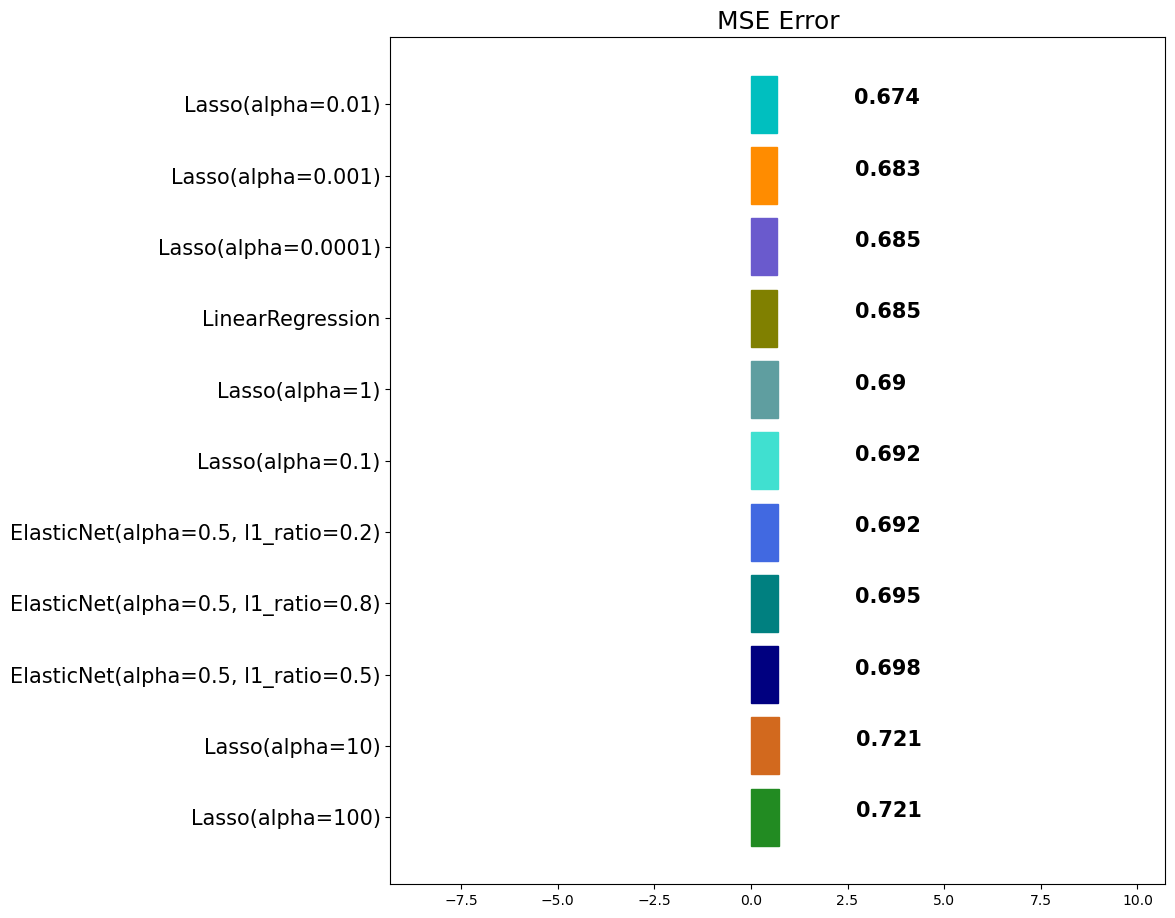

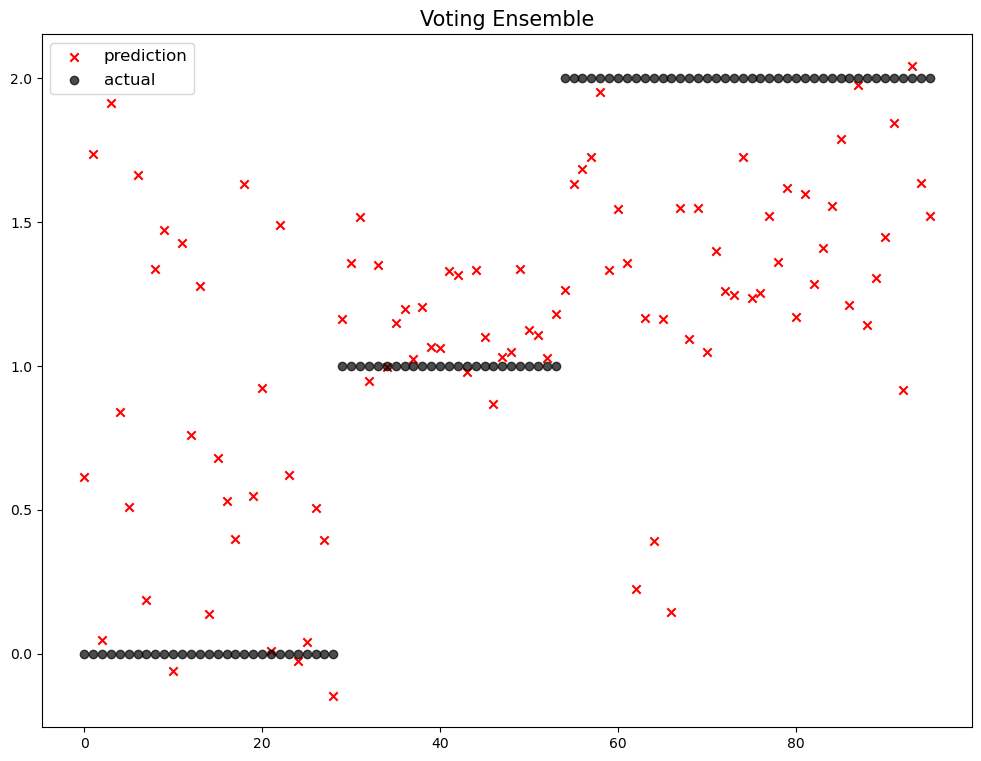

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036
11                      Voting Ensemble  0.539232


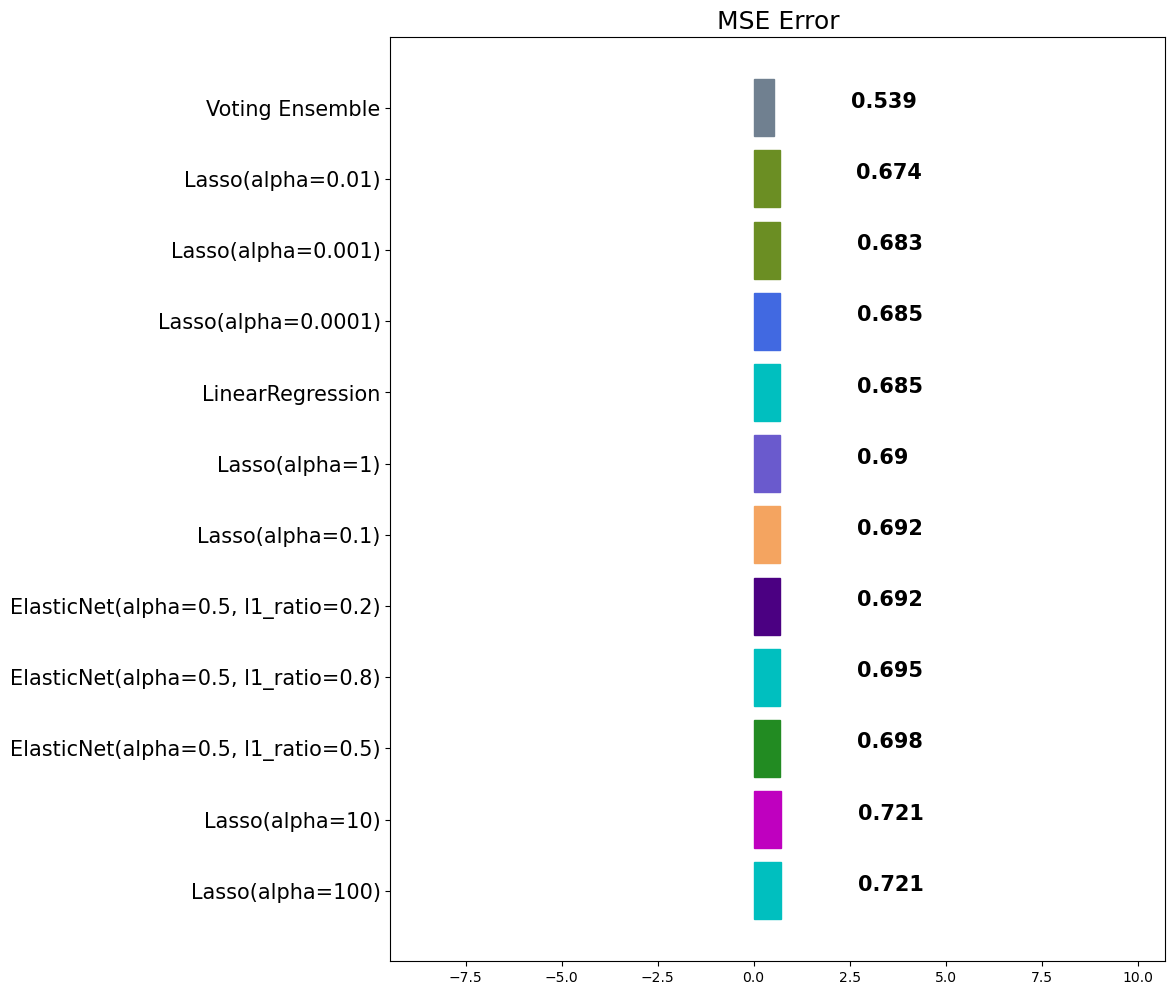

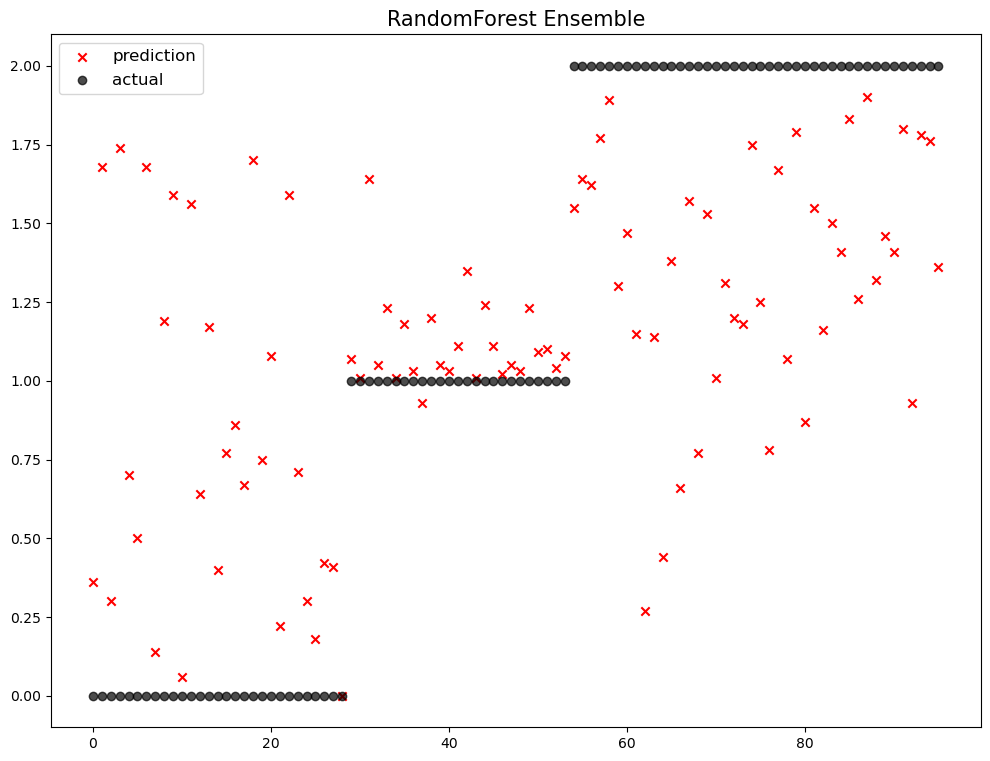

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036
11                RandomForest Ensemble  0.553437
12                      Voting Ensemble  0.539232


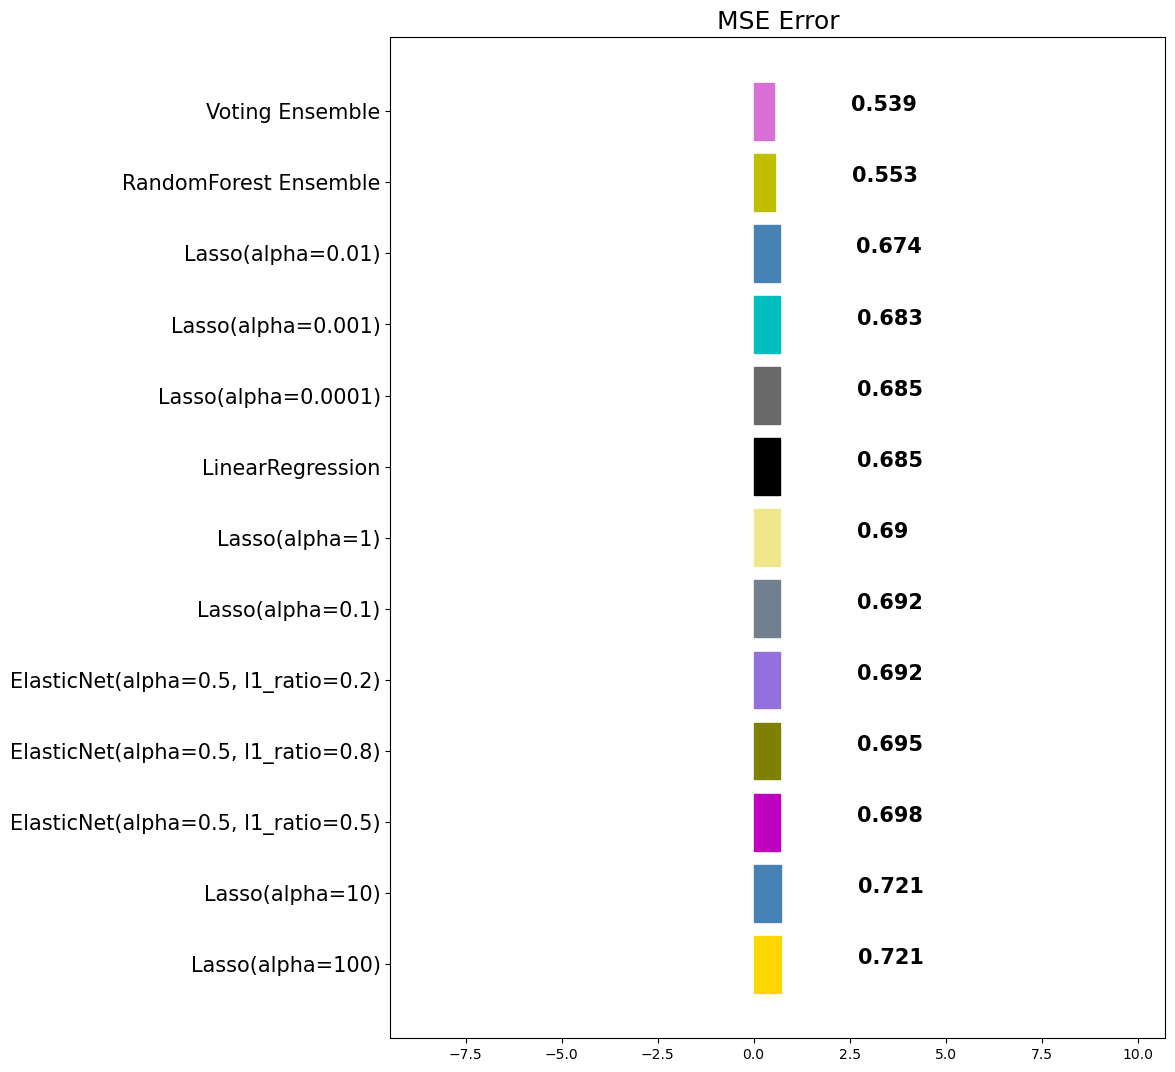

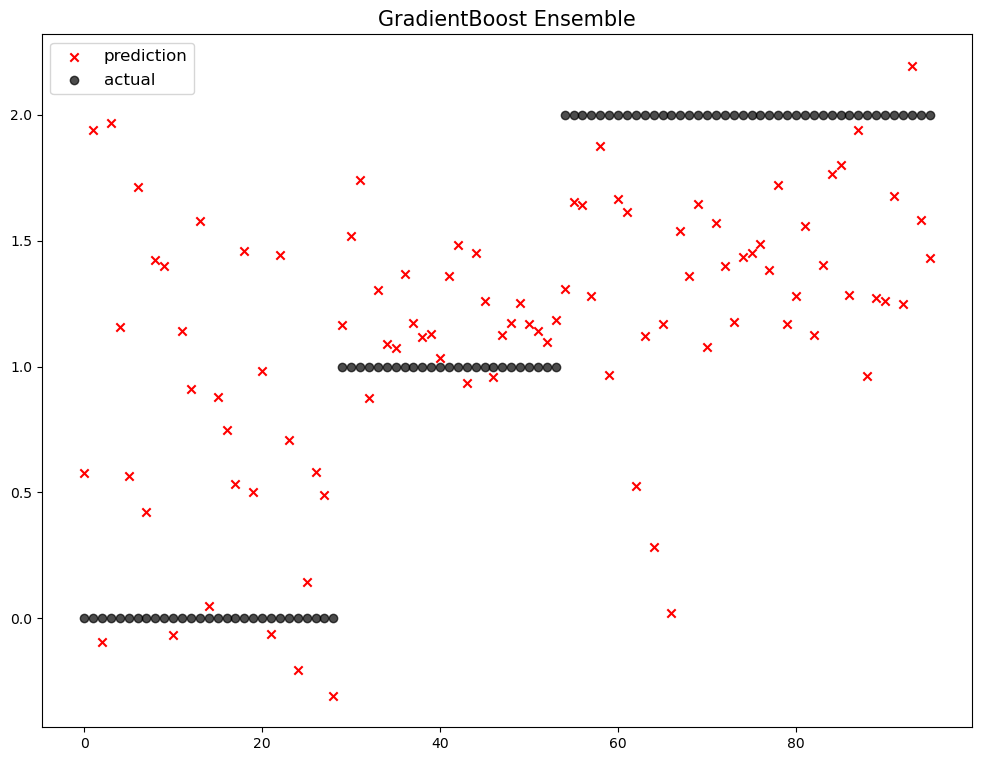

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036
11               GradientBoost Ensemble  0.576997
12                RandomForest Ensemble  0.553437
13                      Voting Ensemble  0.539232


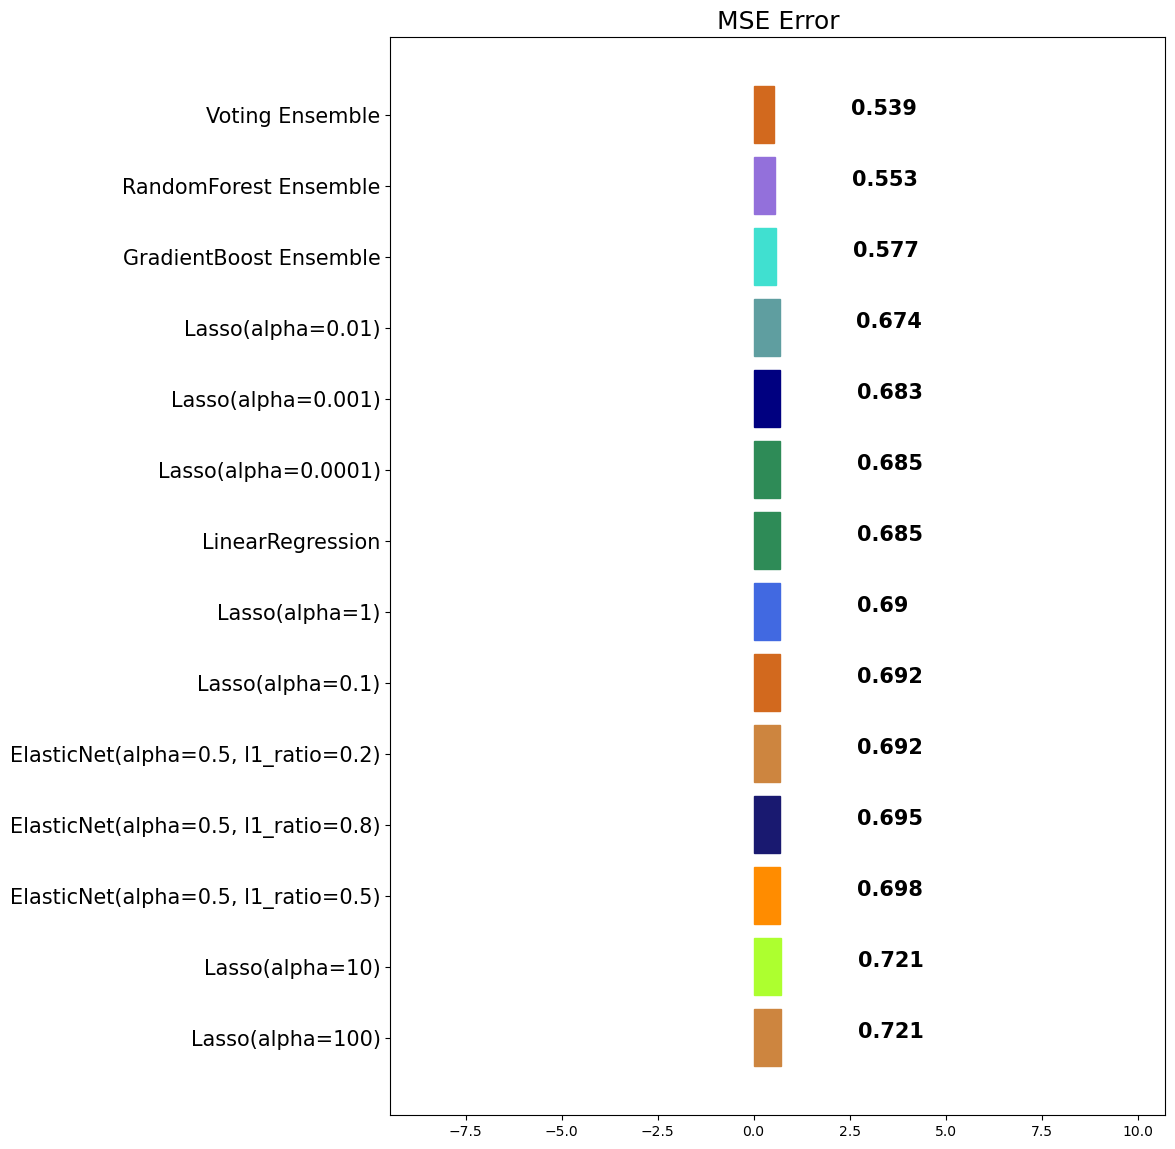

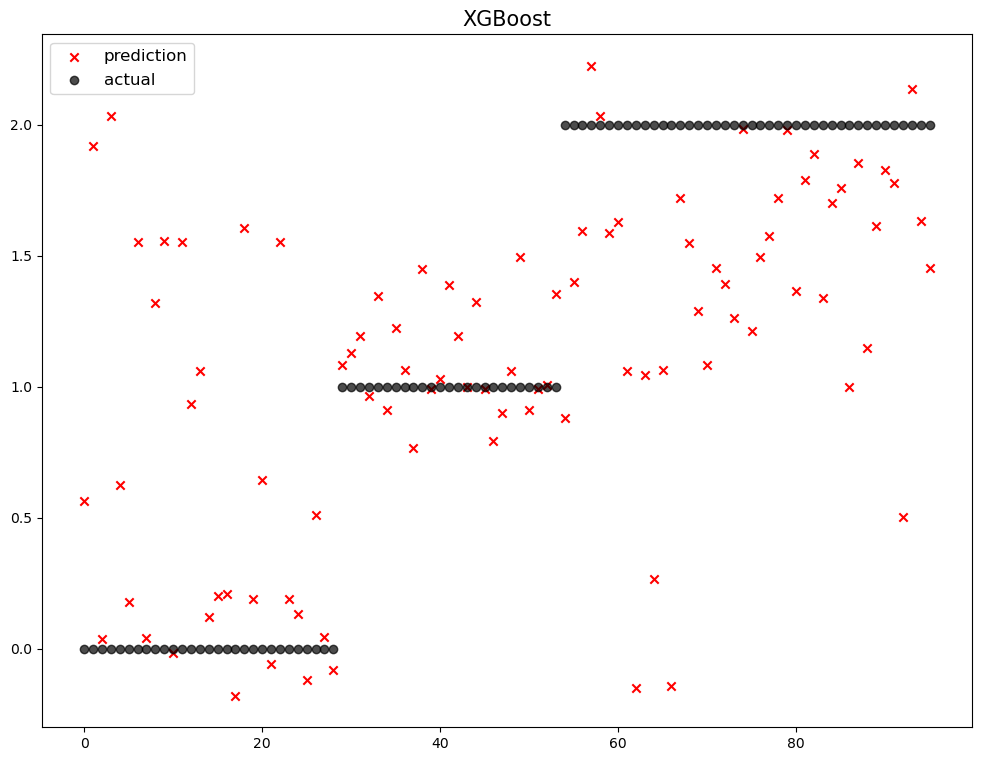

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036
11               GradientBoost Ensemble  0.576997
12                              XGBoost  0.556298
13                RandomForest Ensemble  0.553437
14                      Voting Ensemble  0.539232


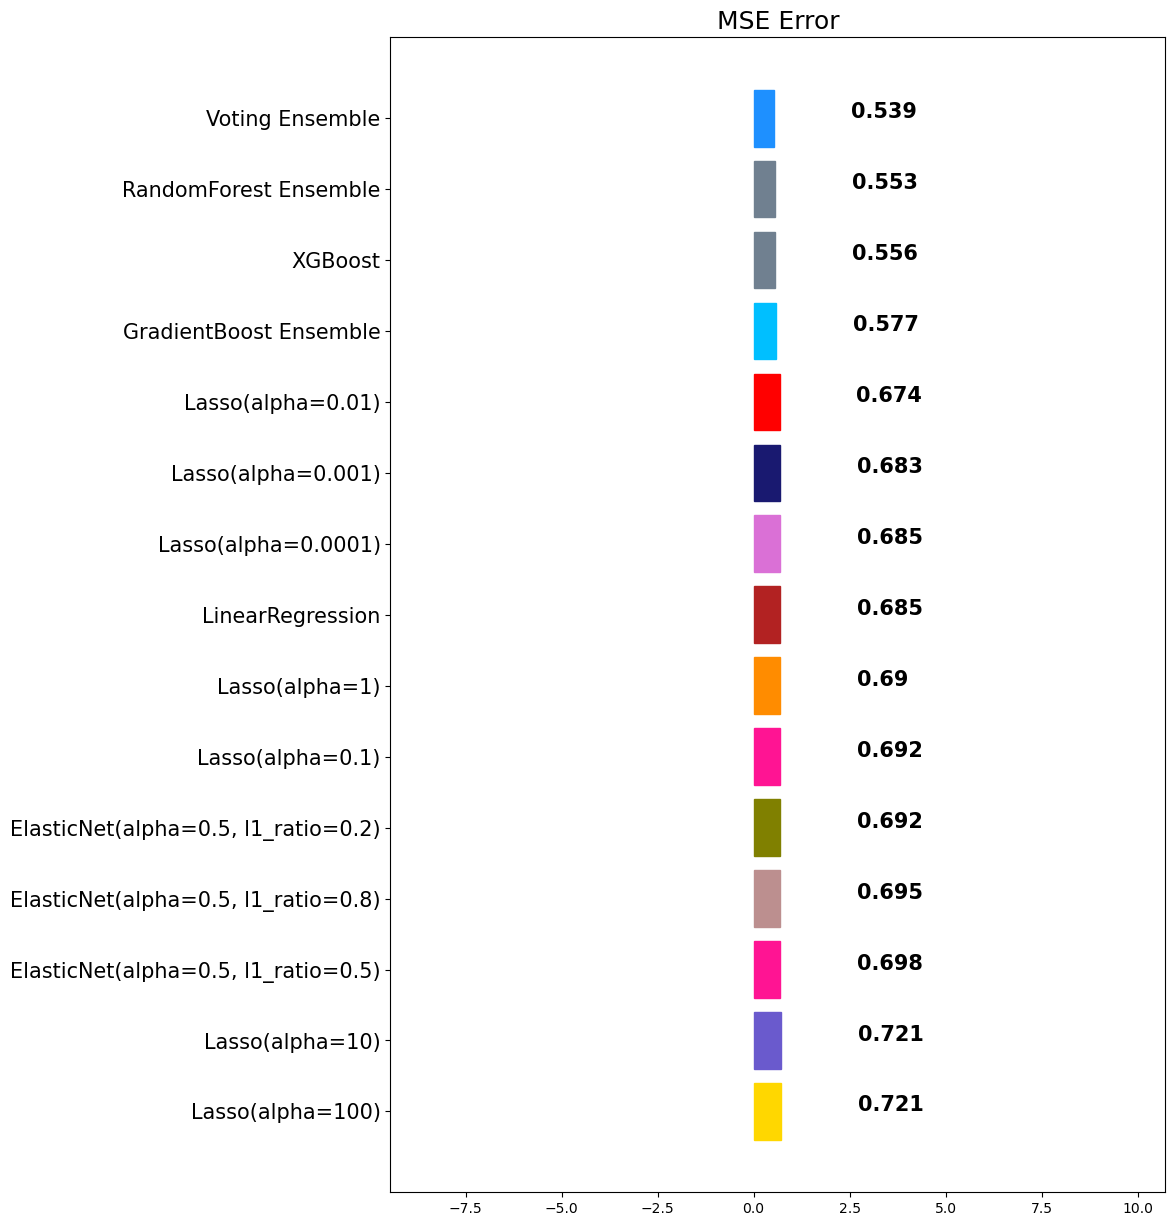

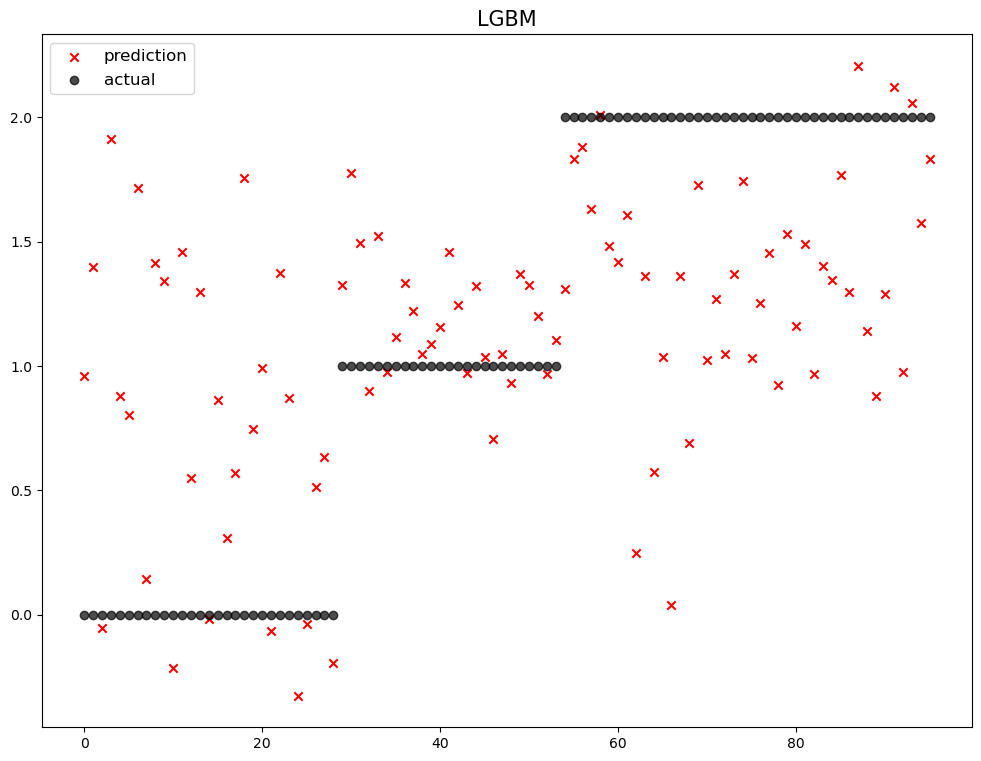

                                  model       mse
0                      Lasso(alpha=100)  0.721354
1                       Lasso(alpha=10)  0.721354
2   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
3   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
4   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
5                      Lasso(alpha=0.1)  0.692206
6                        Lasso(alpha=1)  0.690370
7                      LinearRegression  0.684775
8                   Lasso(alpha=0.0001)  0.684560
9                    Lasso(alpha=0.001)  0.682624
10                    Lasso(alpha=0.01)  0.674036
11                                 LGBM  0.598480
12               GradientBoost Ensemble  0.576997
13                              XGBoost  0.556298
14                RandomForest Ensemble  0.553437
15                      Voting Ensemble  0.539232


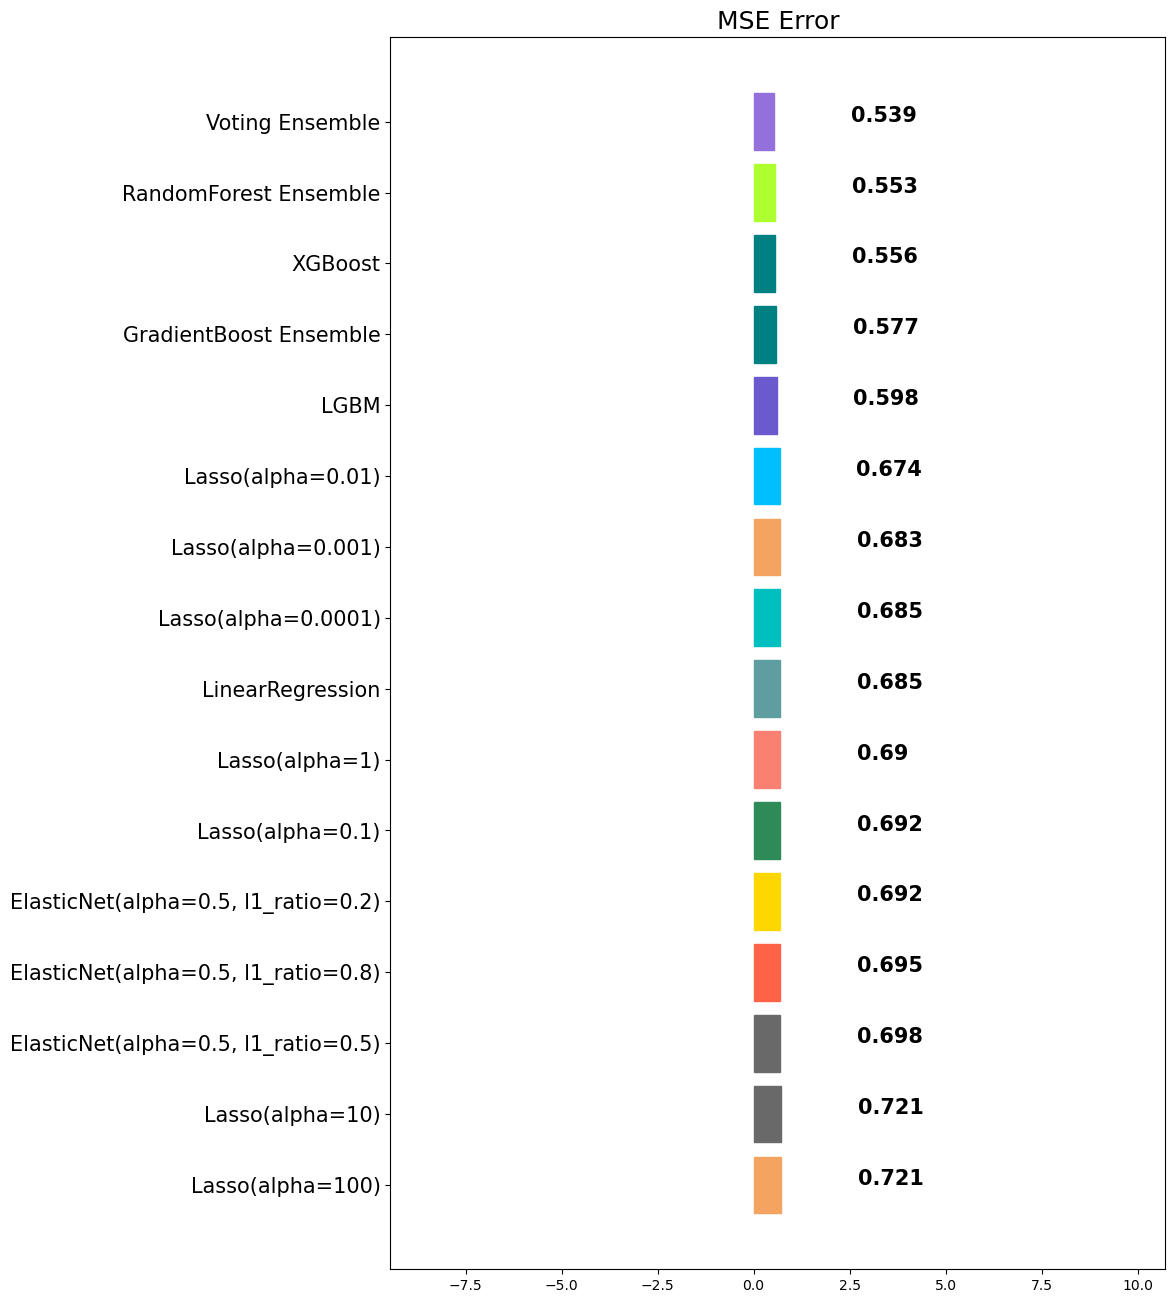

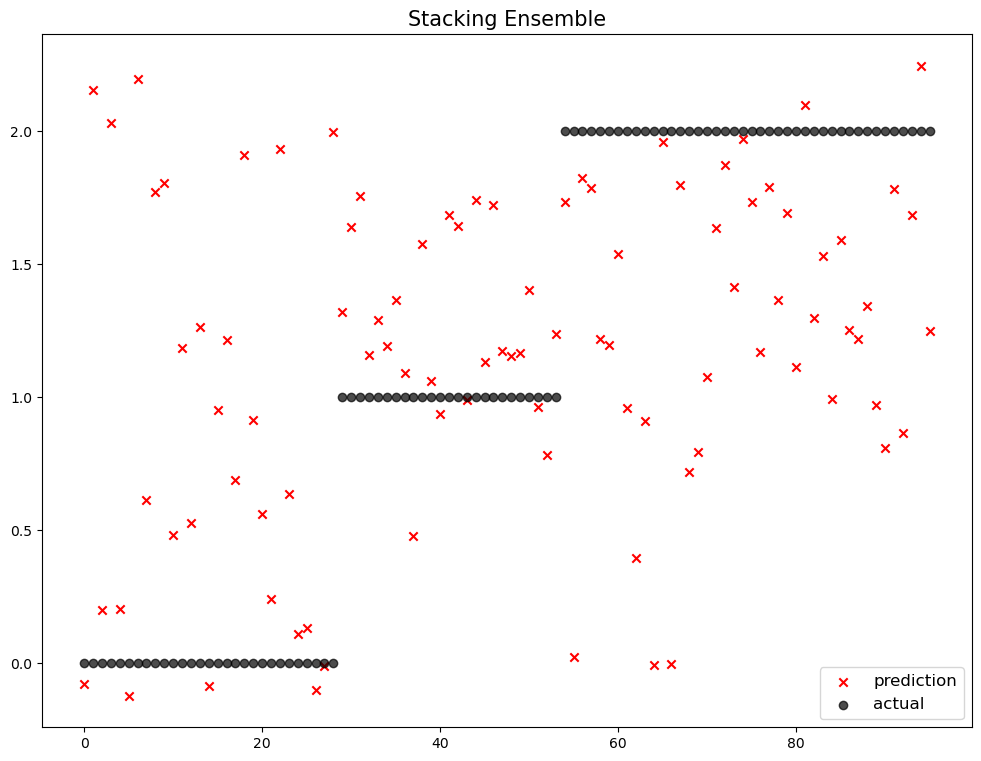

                                  model       mse
0                     Stacking Ensemble  0.804220
1                      Lasso(alpha=100)  0.721354
2                       Lasso(alpha=10)  0.721354
3   ElasticNet(alpha=0.5, l1_ratio=0.5)  0.697957
4   ElasticNet(alpha=0.5, l1_ratio=0.8)  0.695167
5   ElasticNet(alpha=0.5, l1_ratio=0.2)  0.692435
6                      Lasso(alpha=0.1)  0.692206
7                        Lasso(alpha=1)  0.690370
8                      LinearRegression  0.684775
9                   Lasso(alpha=0.0001)  0.684560
10                   Lasso(alpha=0.001)  0.682624
11                    Lasso(alpha=0.01)  0.674036
12                                 LGBM  0.598480
13               GradientBoost Ensemble  0.576997
14                              XGBoost  0.556298
15                RandomForest Ensemble  0.553437
16                      Voting Ensemble  0.539232


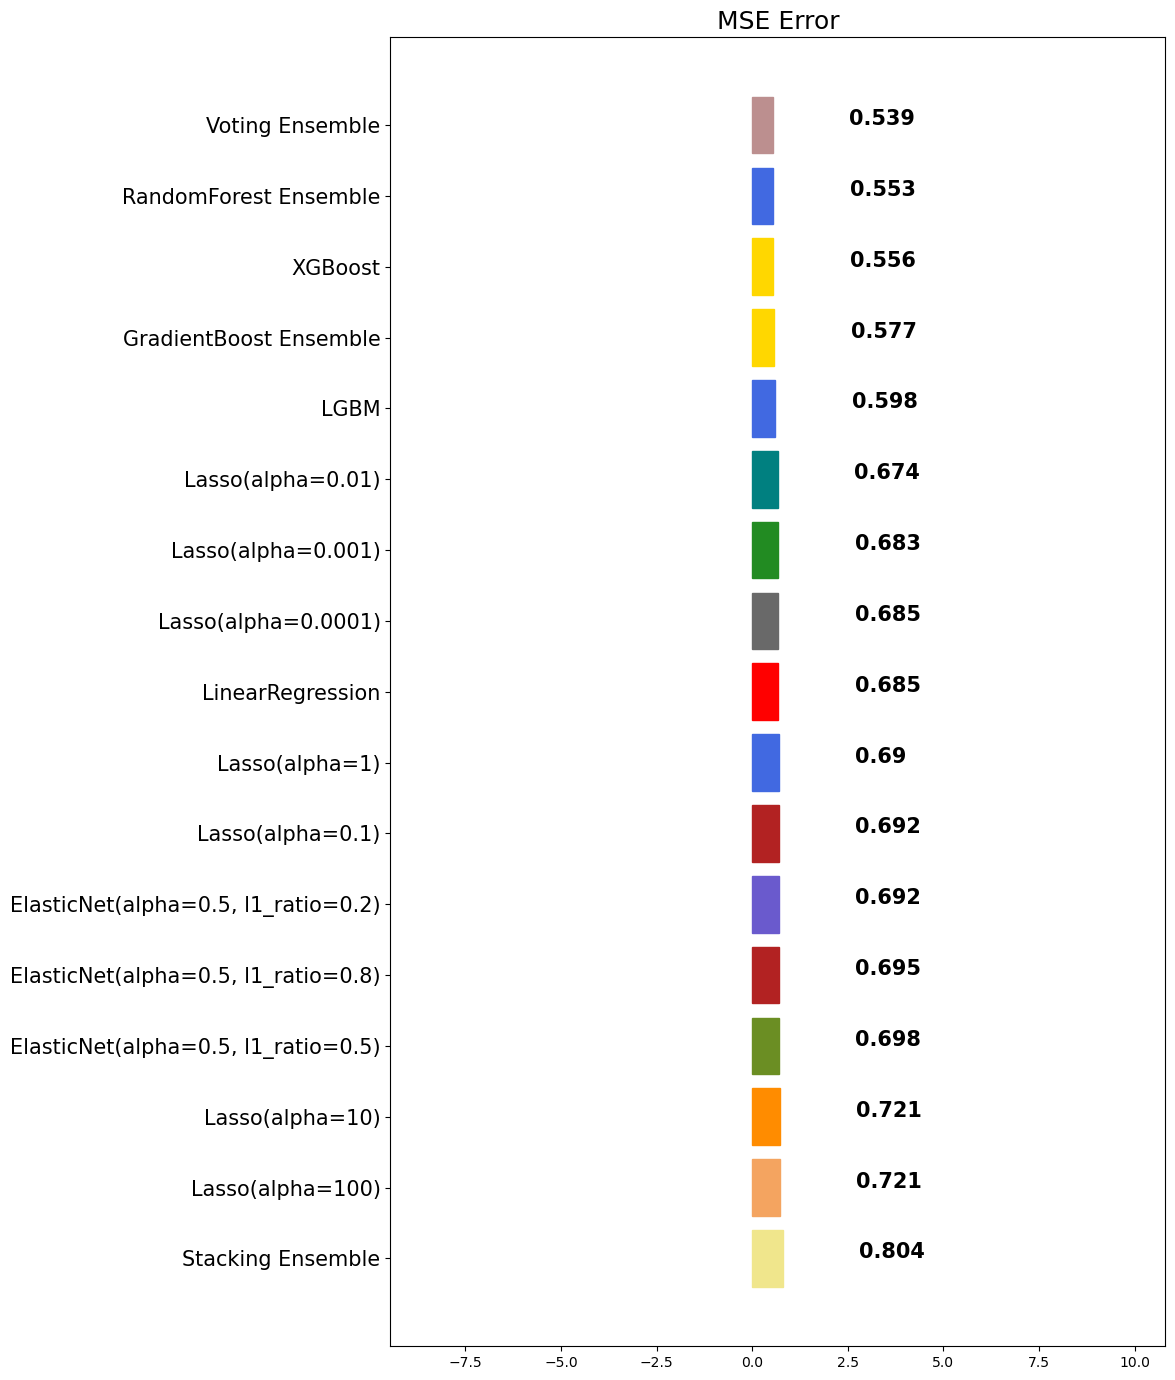

In [608]:
estimator_list = [
    ("RandomForest", RandomForestRegressor(random_state=my_random_state)),
    ("XGBoost", XGBRegressor(random_state=my_random_state)),
    ("GradientBoost", GradientBoostingRegressor(random_state=my_random_state)),
    ("LGBM", LGBMRegressor(random_state=my_random_state, verbose=-1))
]
exec_LinearRegression(x_train, y_train, x_test, y_test)
exec_Lasso(x_train, y_train, x_test, y_test)
exec_ElasticNet(x_train, y_train, x_test, y_test, 0.5)
# exec_PolynomialFeatures_StandardScaler(x_train, y_train, x_test, y_test, 8, )
exec_VotingRegressor(x_train, y_train, x_test, y_test, estimator_list)
exec_RandomForestRegressor(x_train, y_train, x_test, y_test)
exec_GradientBoostingRegressor(x_train, y_train, x_test, y_test)
exec_XGBRegressor(x_train, y_train, x_test, y_test)
exec_LGBMRegressor(x_train, y_train, x_test, y_test)
exec_StackingRegressor(x_train, y_train, x_test, y_test, estimator_list)

### KFold

In [610]:
for estimator in estimator_list:
    exec_kfold(estimator[1], x_data, y_data, 5)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
#0. 교차 검증 MSE: 0.4971
#1. 교차 검증 MSE: 0.6182
#2. 교차 검증 MSE: 0.6916
#3. 교차 검증 MSE: 0.6641
#4. 교차 검증 MSE: 0.6658
평균 MSE: 0.6274
<class 'xgboost.sklearn.XGBRegressor'>
#0. 교차 검증 MSE: 0.5501
#1. 교차 검증 MSE: 0.6354
#2. 교차 검증 MSE: 0.7079
#3. 교차 검증 MSE: 0.7373
#4. 교차 검증 MSE: 0.9261
평균 MSE: 0.7114
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
#0. 교차 검증 MSE: 0.4946
#1. 교차 검증 MSE: 0.6527
#2. 교차 검증 MSE: 0.7233
#3. 교차 검증 MSE: 0.7957
#4. 교차 검증 MSE: 0.6594
평균 MSE: 0.6651
<class 'lightgbm.sklearn.LGBMRegressor'>
#0. 교차 검증 MSE: 0.4713
#1. 교차 검증 MSE: 0.6763
#2. 교차 검증 MSE: 0.7547
#3. 교차 검증 MSE: 0.7030
#4. 교차 검증 MSE: 0.8334
평균 MSE: 0.6877


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Stratified KFold

In [611]:
for estimator in estimator_list:
    exec_stratified_kfold(estimator[1], x_data, y_data, 5)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
#0. 교차 검증 MSE: 0.7296
#1. 교차 검증 MSE: 0.6990
#2. 교차 검증 MSE: 0.6325
#3. 교차 검증 MSE: 0.6159
#4. 교차 검증 MSE: 0.6495
평균 MSE: 0.6653
<class 'xgboost.sklearn.XGBRegressor'>
#0. 교차 검증 MSE: 0.8321
#1. 교차 검증 MSE: 0.9193
#2. 교차 검증 MSE: 0.6296
#3. 교차 검증 MSE: 0.9389
#4. 교차 검증 MSE: 1.0899
평균 MSE: 0.8820
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
#0. 교차 검증 MSE: 0.7512
#1. 교차 검증 MSE: 0.8254
#2. 교차 검증 MSE: 0.6976
#3. 교차 검증 MSE: 0.8970
#4. 교차 검증 MSE: 0.6894
평균 MSE: 0.7721
<class 'lightgbm.sklearn.LGBMRegressor'>
#0. 교차 검증 MSE: 0.6579
#1. 교차 검증 MSE: 0.7459
#2. 교차 검증 MSE: 0.6790
#3. 교차 검증 MSE: 0.6836
#4. 교차 검증 MSE: 0.8018
평균 MSE: 0.7136


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
